In [9]:
import sqlite3

import mysql.connector
from mysql.connector import Error
from itertools import combinations
import time
from collections import Counter
from prettytable import PrettyTable

# 10 tables

In [10]:
l1 = {
    'abbrev': ['Type', 'Code', 'Fullname'],
    'awardscoaches': ['coachID', 'award', 'year', 'lgID'],
    'awardsmisc': ['name', 'ID', 'award', 'year', 'lgID'],
    'awardsplayers': ['playerID', 'award', 'year', 'lgID', 'pos'],
    'coaches': ['coachID', 'year', 'tmID', 'lgID', 'stint'],
    'combinedshutouts': ['year', 'month', 'date', 'tmID', 'oppID', 'R/P', 'IDgoalie1', 'IDgoalie2'],
    'goalies': ['playerID', 'year', 'stint', 'tmID', 'lgID', 'GP'],
    'goaliessc': ['playerID', 'year', 'tmID', 'lgID', 'GP'],
    'goaliesshootout': ['playerID', 'year', 'stint', 'tmID'],
    'hof': ['year', 'hofID', 'name', 'category'],
    'master': ['playerID', 'coachID', 'hofID', 'legendsID', 'ihdbID', 'hrefID', 'lastName', 'nameGiven', 'birthYear', 'pos'],
    'scoring': ['playerID', 'year', 'stint', 'tmID', 'lgID', 'pos'],
    'scoringsc': ['playerID', 'year', 'tmID', 'lgID', 'pos'],
    'scoringshootout': ['playerID', 'year', 'stint', 'tmID'],
    'scoringsup': ['playerID', 'year'],
    'seriespost': ['year', 'round', 'series', 'tmIDWinner', 'lgIDWinner', 'tmIDLoser', 'lgIDLoser'],
    'teams': ['year', 'lgID', 'tmID', 'franchID', 'confID', 'divID', 'rank', 'name'],
    'teamshalf': ['year', 'lgID', 'tmID', 'half', 'rank'],
    'teamsplits': ['year', 'lgID', 'tmID'],
    'teamspost': ['year', 'lgID', 'tmID'],
    'teamssc': ['year', 'lgID', 'tmID'],
    'teamvsteam': ['year', 'lgID', 'tmID', 'oppID']
}

total_table = PrettyTable()
total_table.field_names = ['Table Name', 'Columns']


for key, values in l1.items():
    col = ', '.join(v for v in values)
    total_table.add_row([key, col])
    
print(total_table)


+------------------+------------------------------------------------------------------------------------------+
|    Table Name    |                                         Columns                                          |
+------------------+------------------------------------------------------------------------------------------+
|      abbrev      |                                   Type, Code, Fullname                                   |
|  awardscoaches   |                                coachID, award, year, lgID                                |
|    awardsmisc    |                               name, ID, award, year, lgID                                |
|  awardsplayers   |                             playerID, award, year, lgID, pos                             |
|     coaches      |                             coachID, year, tmID, lgID, stint                             |
| combinedshutouts |                year, month, date, tmID, oppID, R/P, IDgoalie1, IDgoalie2           

# Method
## Uniqueness Ratio 
## Completeness Ratio

In [11]:
def get_column_names(cursor, table_name):
    """Get all column names of a database table"""
    cursor.execute(f"DESCRIBE `{table_name}`")
    return [column[0] for column in cursor.fetchall()]


# Uniqueness Ratio
def pmax_uniqueness_ratio_sql(cursor, table_name, columns):
    """Calculates the Uniqueness Ratio for a given column permutation"""
    if not columns:
        return 0, 0
    columns_list = ', '.join([f"`{col}`" for col in columns])
    query = f"""
        SELECT
            ((null_rows + unique_rows) / total_rows) AS uniqueness_ratio
        FROM (
            SELECT
                (SELECT COUNT(*) FROM {table_name} WHERE {' OR '.join([f"`{col}` IS NULL" for col in columns])}) AS null_rows,
                (
                    SELECT COUNT(*)
                    FROM (
                        SELECT {columns_list}
                        FROM `{table_name}`
                        WHERE {' AND '.join([f"`{col}` IS NOT NULL" for col in columns])}
                        GROUP BY {columns_list}
                        HAVING COUNT(*) = 1
                    ) AS unique_data
                ) AS unique_rows,
                (SELECT COUNT(*) FROM {table_name}) AS total_rows
        ) AS results;
    """
    start_time = time.time()
    cursor.execute(query)
    result = cursor.fetchone()
    execution_time = time.time() - start_time
    ratio = result[0] if result else 0

    return ratio, execution_time


# Completeness Ratio
def completeness_ratio(cursor, table_name, columns):
    if not columns:
        return 0

    cursor.execute(f"SELECT COUNT(*) FROM `{table_name}`;")
    total_counts = cursor.fetchone()[0]

    query = " AND ".join([f"`{col}` IS NOT NULL" for col in columns])
    cursor.execute(f"SELECT COUNT(*) FROM `{table_name}` WHERE {query};")
    non_null_count = cursor.fetchone()[0]

    return non_null_count/total_counts


# Show All Ratios in Tables

In [12]:
def main_ur(user, password, database, table_name, columns):
    connection = None
    try:
        connection = mysql.connector.connect(user=user, password=password, database=database, host='localhost')
        
        if connection.is_connected():
            cursor = connection.cursor()
            all_combinations = [combo for length in range(1, len(columns) + 1) for combo in combinations(columns, length)]
            execution_times_by_length = {}
            detailed_output = []

            for perm in all_combinations:
                ur, exec_time = pmax_uniqueness_ratio_sql(cursor, table_name, perm)
                cr = completeness_ratio(cursor, table_name, perm)
                key = len(perm)
                
                if key in execution_times_by_length:
                    execution_times_by_length[key].append(exec_time)
                else:
                    execution_times_by_length[key] = [exec_time]
                detailed_output.append((perm, ur, cr, exec_time))
                    
            table = PrettyTable()
            table.field_names = ['Key', 'Uniqueness Ratio', 'Completeness Ratio', 'Running Time for UR']
        
            for perm, ur, cr, exec_time in detailed_output:
                table.add_row([', '.join(perm), f'{ur:.4f}', f'{cr:.4f}', f'{exec_time:.4f}'])
                # print(f"Columns: {', '.join(perm)} | Uniqueness Ratio: {ratio:.4f} | Time: {exec_time:.4f} seconds")
            print(table)

    except Error as e:
        print("Error:", e)
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()


In [13]:
for key, values in l1.items():
    print(f"Table: {key}\nColumns: {values}")
    main_ur(user="root", password="yzh_20010315", database="hockey", table_name=key, columns=values)

Table: abbrev
Columns: ['Type', 'Code', 'Fullname']
+----------------------+------------------+--------------------+---------------------+
|         Key          | Uniqueness Ratio | Completeness Ratio | Running Time for UR |
+----------------------+------------------+--------------------+---------------------+
|         Type         |      0.0000      |       1.0000       |        0.0013       |
|         Code         |      0.6552      |       1.0000       |        0.0009       |
|       Fullname       |      1.0000      |       1.0000       |        0.0014       |
|      Type, Code      |      1.0000      |       1.0000       |        0.0008       |
|    Type, Fullname    |      1.0000      |       1.0000       |        0.0009       |
|    Code, Fullname    |      1.0000      |       1.0000       |        0.0006       |
| Type, Code, Fullname |      1.0000      |       1.0000       |        0.0008       |
+----------------------+------------------+--------------------+--------------

# MAX Ratio / MIN Ratio / AVERAGE Ratio

In [14]:
import matplotlib.pyplot as plt

def calculation(user, password, database, table_name, columns):
    try:
        connection = mysql.connector.connect(user=user, password=password, database=database)

        if connection.is_connected():
            cursor = connection.cursor()
            # columns = get_column_names(cursor, table_name)
            all_combinations = [combo for length in range(1, len(columns)+1) for combo in
                                combinations(columns, length)]
            execution_times_by_length = {}
            detailed_output = {}

            # 计算每种列组合的 uniqueness ratio
            for perm in all_combinations:
                ur, exec_time = pmax_uniqueness_ratio_sql(cursor, table_name, perm)
                cr = completeness_ratio(cursor, table_name, perm)
                
                key = len(perm)

                if key in execution_times_by_length:
                    execution_times_by_length[key].append(exec_time)
                    detailed_output[key].append((perm, ur, cr, exec_time))
                else:
                    execution_times_by_length[key] = [exec_time]
                    detailed_output[key] = [(perm, ur, cr, exec_time)]

            # Calculate average execution time by length of column combination
            avg_times = []
            lengths = []
            for length, times in sorted(execution_times_by_length.items()):
                avg_time = sum(times) / len(times)
                avg_times.append(avg_time)
                lengths.append(length)

    except Error as e:
        print("Error:", e)
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()

    return detailed_output, avg_times, lengths

def plt_box(database, table_name, columns):
    detailed_output, avg_times, lengths = calculation('root', 'yzh_20010315', database, table_name, columns)

    # 将 detailed output 当中的 uniqueness ratio 从 Decimal 转换成 float 类型。
    # uniqueness_ratios_by_length 里面值存储列组合的个数和 uniqueness ratio，而没有具体是哪个列。以便后续绘制箱形图
    uniqueness_ratios_by_length = {}
    for key, values in detailed_output.items():
        if key not in uniqueness_ratios_by_length:
            uniqueness_ratios_by_length[key] = []
        uniqueness_ratios_by_length[key].extend([float(entry[1]) for entry in values])
    
    
    # print("Decimal: ", detailed_output)
    # print("Float: ", uniqueness_ratios_by_length)
    
    lengths = sorted(uniqueness_ratios_by_length.keys())
    ratio_lists = [uniqueness_ratios_by_length[l] for l in lengths]
    
    fig, ax = plt.subplots()
    box = ax.boxplot(ratio_lists, labels=[str(length) for length in lengths], whis=[0, 100])

    ax.set_xlabel('Size of Column Set')
    ax.set_ylabel('Maximum Uniqueness Ratio')
    ax.set_title(f'Maximum Uniqueness Ratio Distribution of {table_name}')
    
    # 为每个箱形图添加最大值、最小值和中位数的注释
    for i, line in enumerate(box['whiskers']):
        # Whiskers 在返回列表中是每两个一组，分别代表下界和上界
        x, y = line.get_xydata()[1]  # get_xydata() 返回线的两端点(x0, y0), (x1, y1)，我们需要的是 x1, y1
        if i % 2 == 0:  # 下界
            ax.annotate(f'{y:.4f}', xy=(x, y), xytext=(-20, -10), textcoords='offset points', ha='left', va='baseline', color = 'blue')
        else:  # 上界
            ax.annotate(f'{y:.4f}', xy=(x, y), xytext=(-20, 10), textcoords='offset points', ha='left', va='baseline', color = 'red')

    for i, line in enumerate(box['medians']):
        # 中位数
        x, y = line.get_xydata()[1]
        ax.annotate(f'{y:.4f}', xy=(x, y), xytext=(-20, 0), textcoords='offset points', ha='center', va='baseline', color='orange')

    plt.show()


In [15]:
def plt_box2(database, table_name, columns):
    detailed_output, avg_times, lengths = calculation('root', 'yzh_20010315', database, table_name, columns)

    # 将 detailed output 当中的 uniqueness ratio 从 Decimal 转换成 float 类型。
    uniqueness_ratios_by_length = {}
    for key, values in detailed_output.items():
        if key not in uniqueness_ratios_by_length:
            uniqueness_ratios_by_length[key] = []
        uniqueness_ratios_by_length[key].extend([float(entry[1]) for entry in values])
    
    # 按照列组合长度对箱型图进行绘制
    lengths = sorted(uniqueness_ratios_by_length.keys())
    ratio_lists = [uniqueness_ratios_by_length[l] for l in lengths]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    box = ax.boxplot(ratio_lists, labels=[str(length) for length in lengths], whis=[0, 100], showmeans=True)

    ax.set_xlabel('Size of Column Set')
    ax.set_ylabel('Maximum Uniqueness Ratio')
    ax.set_title(f'Maximum Uniqueness Ratio Distribution of {table_name}')
    
    for i, length in enumerate(lengths):
        q1 = box['boxes'][i].get_ydata()[1]  # 下四分位数 Q1
        q3 = box['boxes'][i].get_ydata()[2]  # 上四分位数 Q3
        median = box['medians'][i].get_ydata()[1]  # 中位数
        lower_whisker = box['whiskers'][2*i].get_ydata()[1]  # 最小值
        upper_whisker = box['whiskers'][2*i+1].get_ydata()[1]  # 最大值
    
        # 四分位数和中位数的错位显示
        offset = 15 if i % 2 == 0 else -15
    
        ax.annotate(f'Q1: {q1:.4f}', xy=(i+1, q1), xytext=(-40, offset), textcoords='offset points', ha='right', va='center', color='orange')
        ax.annotate(f'Q3: {q3:.4f}', xy=(i+1, q3), xytext=(-40, -offset), textcoords='offset points', ha='right', va='center', color='orange')
        ax.annotate(f'Median: {median:.4f}', xy=(i+1, median), xytext=(-40, offset), textcoords='offset points', ha='right', va='center', color='green')
    
        # 最大值和最小值的错位显示
        ax.annotate(f'Max: {upper_whisker:.4f}', xy=(i+1, upper_whisker), xytext=(20, offset), textcoords='offset points', ha='left', va='center', color='red')
        ax.annotate(f'Min: {lower_whisker:.4f}', xy=(i+1, lower_whisker), xytext=(20, -offset), textcoords='offset points', ha='left', va='center', color='blue')


    plt.tight_layout()
    plt.show()


Table: abbrev
Columns: ['Type', 'Code', 'Fullname']


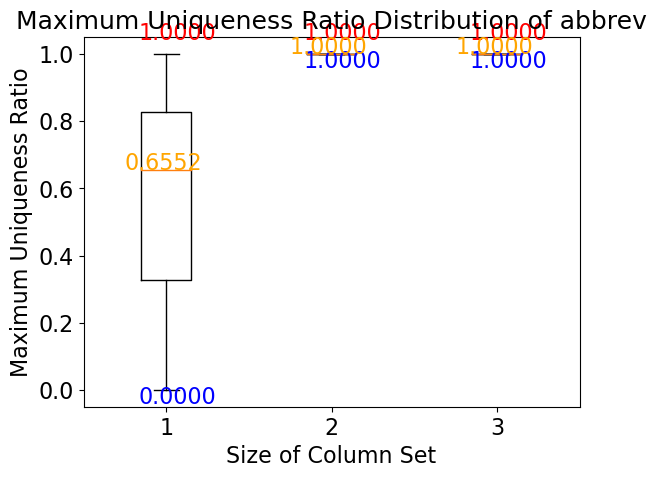

Table: awardscoaches
Columns: ['coachID', 'award', 'year', 'lgID']


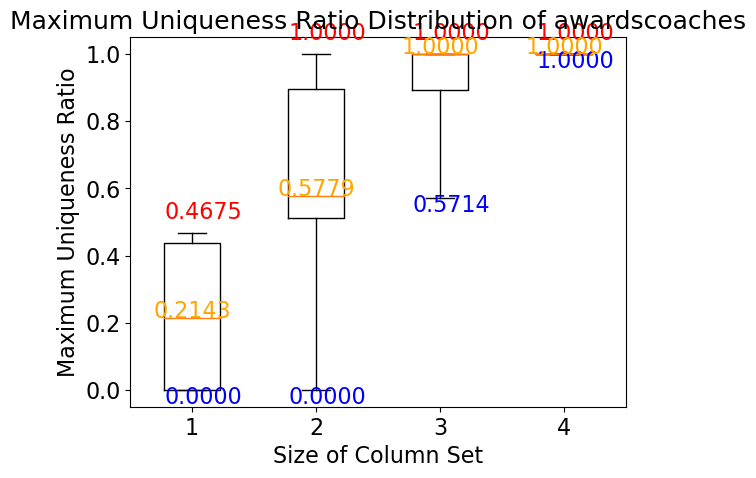

Table: awardsmisc
Columns: ['name', 'ID', 'award', 'year', 'lgID']


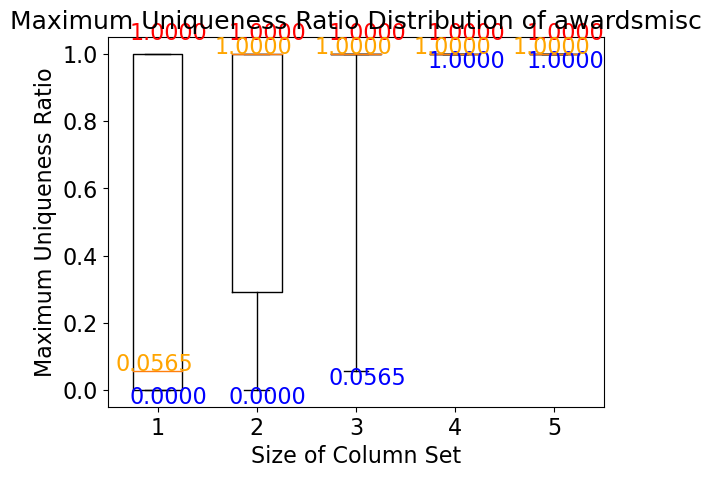

Table: awardsplayers
Columns: ['playerID', 'award', 'year', 'lgID', 'pos']


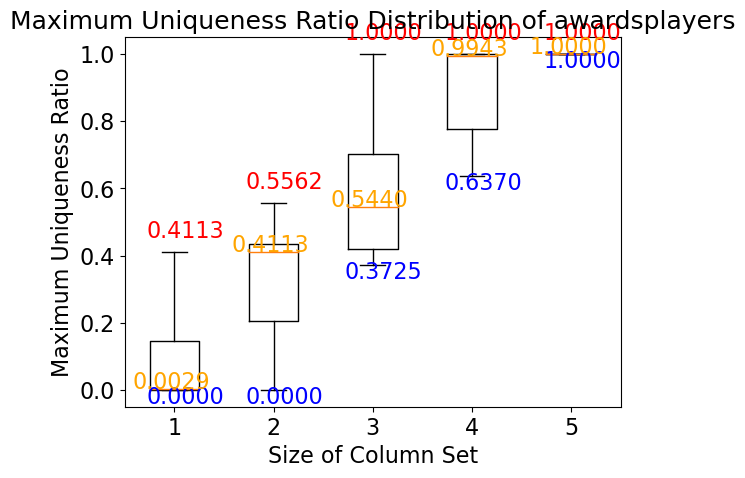

Table: coaches
Columns: ['coachID', 'year', 'tmID', 'lgID', 'stint']


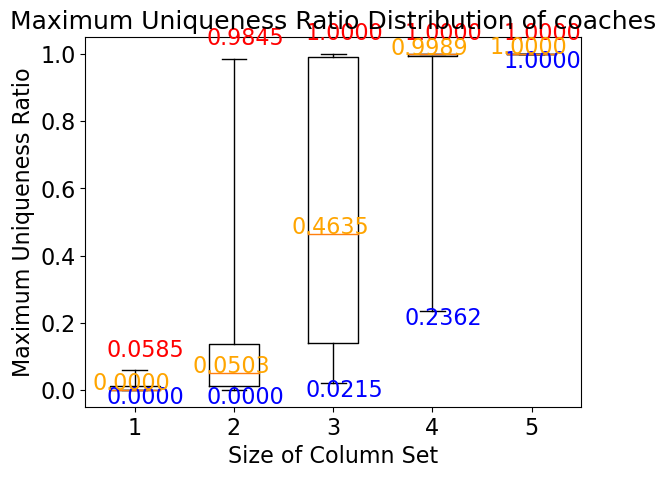

Table: combinedshutouts
Columns: ['year', 'month', 'date', 'tmID', 'oppID', 'R/P', 'IDgoalie1', 'IDgoalie2']


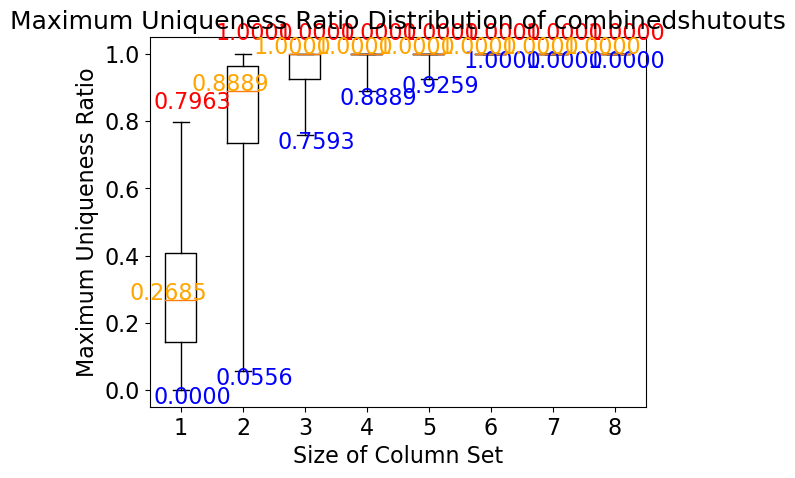

Table: goalies
Columns: ['playerID', 'year', 'stint', 'tmID', 'lgID', 'GP']


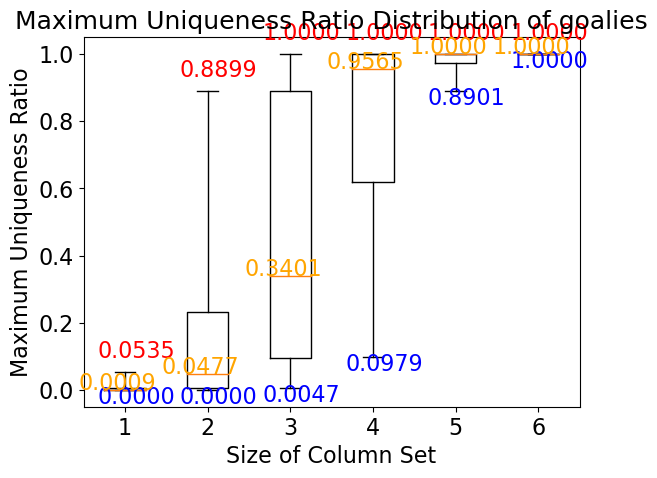

Table: goaliessc
Columns: ['playerID', 'year', 'tmID', 'lgID', 'GP']


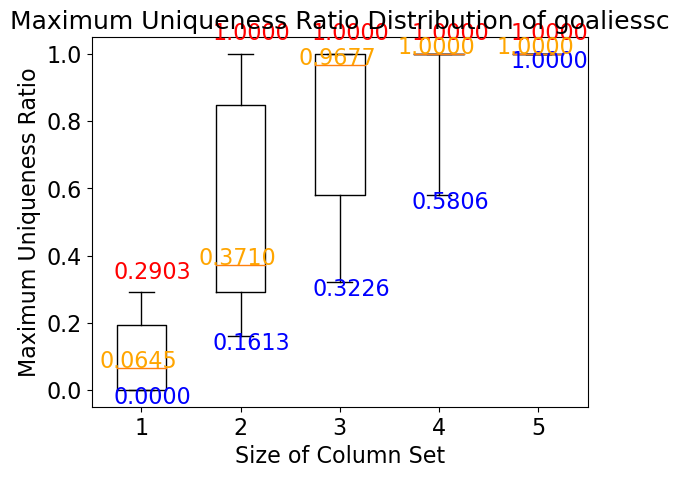

Table: goaliesshootout
Columns: ['playerID', 'year', 'stint', 'tmID']


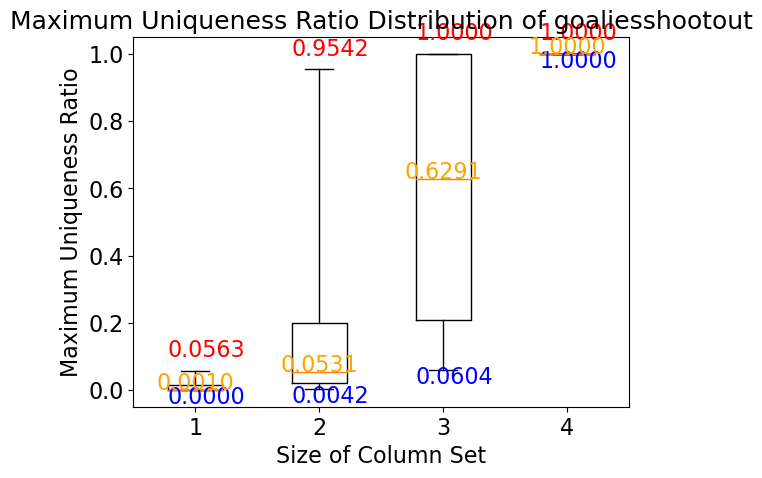

Table: hof
Columns: ['year', 'hofID', 'name', 'category']


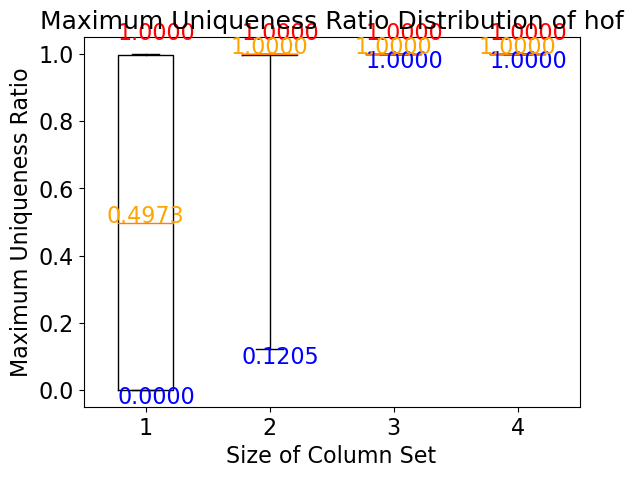

Table: master
Columns: ['playerID', 'coachID', 'hofID', 'legendsID', 'ihdbID', 'hrefID', 'lastName', 'nameGiven', 'birthYear', 'pos']


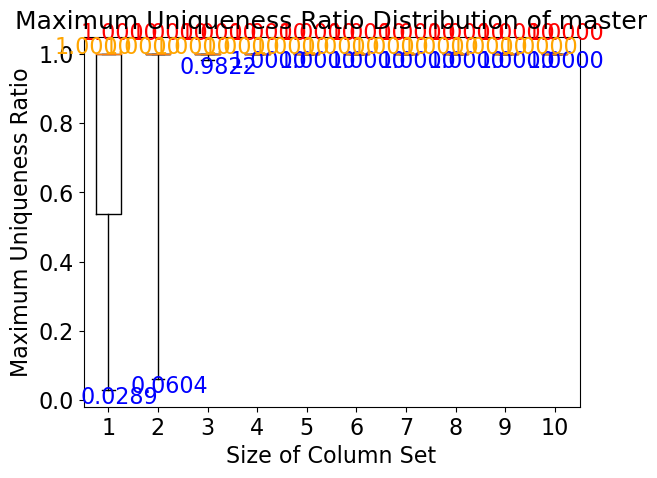

Table: scoring
Columns: ['playerID', 'year', 'stint', 'tmID', 'lgID', 'pos']


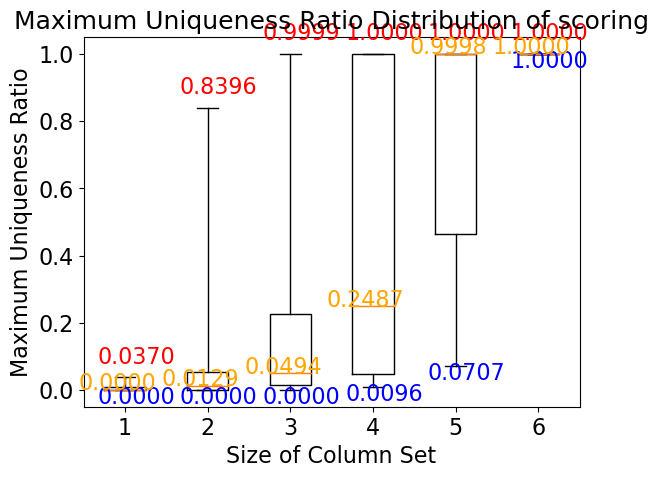

Table: scoringsc
Columns: ['playerID', 'year', 'tmID', 'lgID', 'pos']


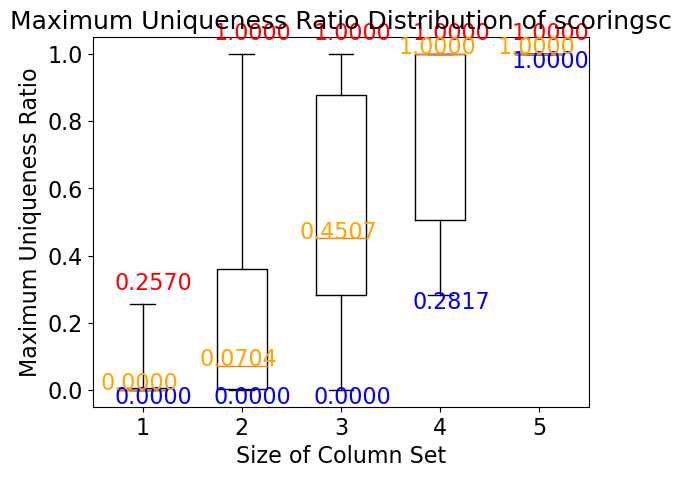

Table: scoringshootout
Columns: ['playerID', 'year', 'stint', 'tmID']


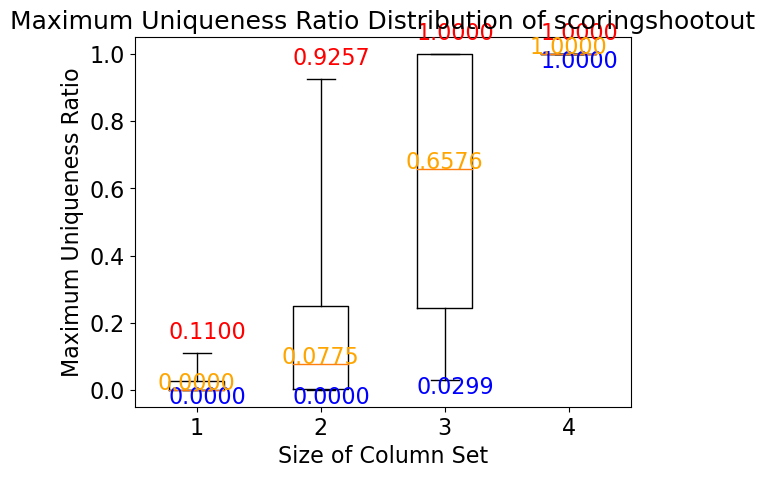

Table: scoringsup
Columns: ['playerID', 'year']


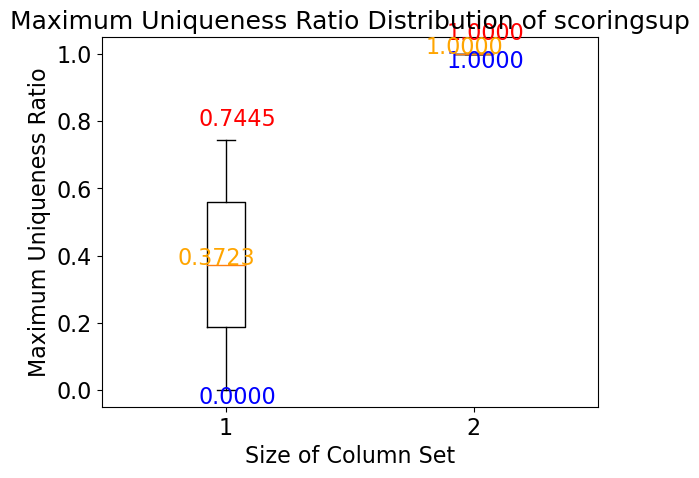

Table: seriespost
Columns: ['year', 'round', 'series', 'tmIDWinner', 'lgIDWinner', 'tmIDLoser', 'lgIDLoser']


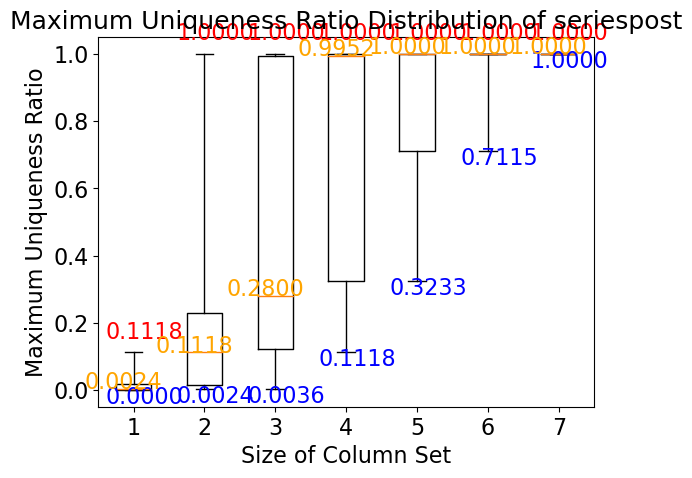

Table: teams
Columns: ['year', 'lgID', 'tmID', 'franchID', 'confID', 'divID', 'rank', 'name']


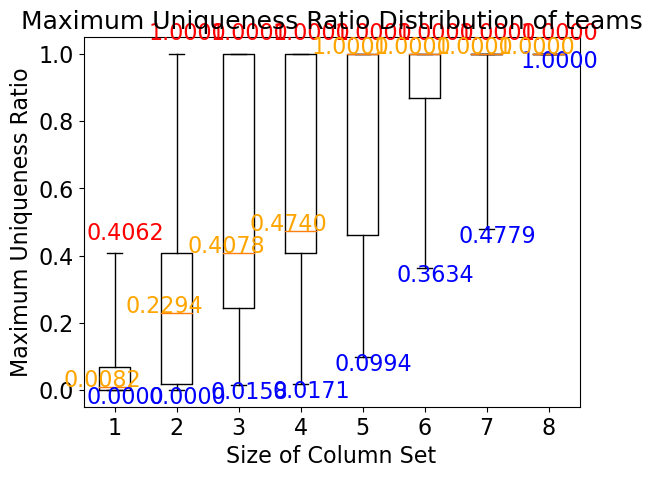

Table: teamshalf
Columns: ['year', 'lgID', 'tmID', 'half', 'rank']


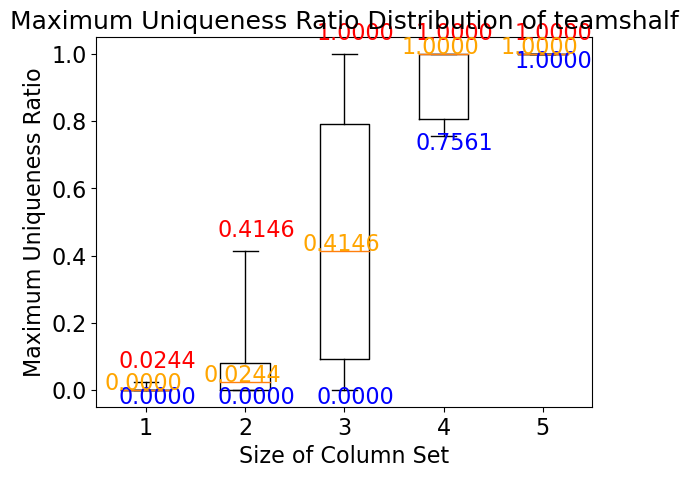

Table: teamsplits
Columns: ['year', 'lgID', 'tmID']


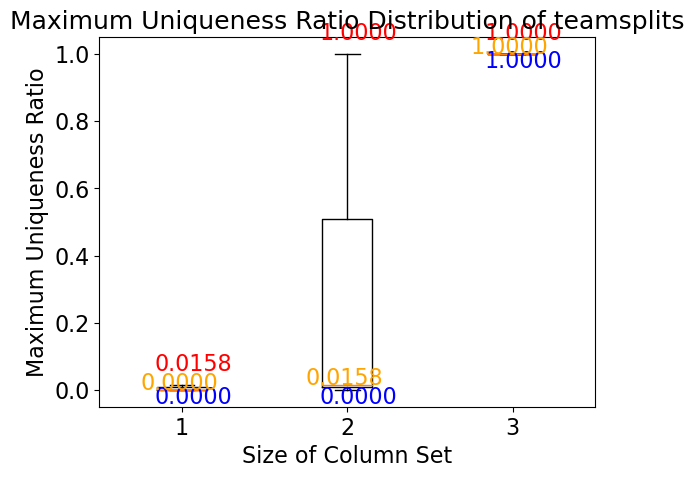

Table: teamspost
Columns: ['year', 'lgID', 'tmID']


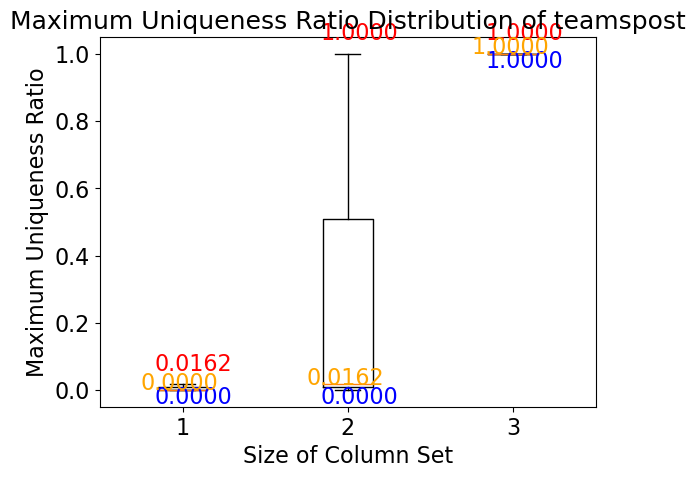

Table: teamssc
Columns: ['year', 'lgID', 'tmID']


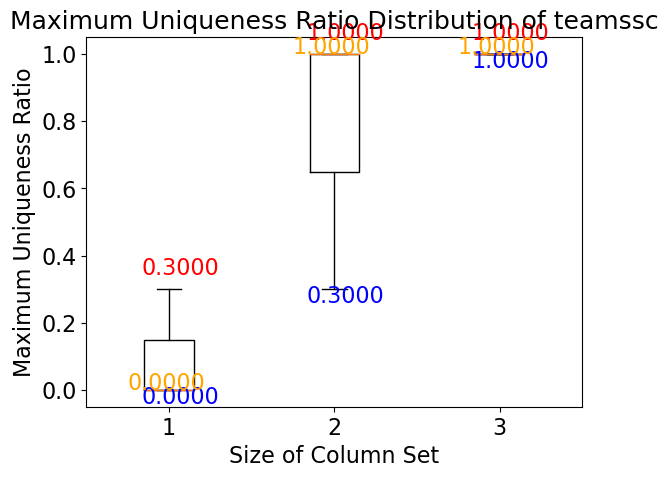

Table: teamvsteam
Columns: ['year', 'lgID', 'tmID', 'oppID']


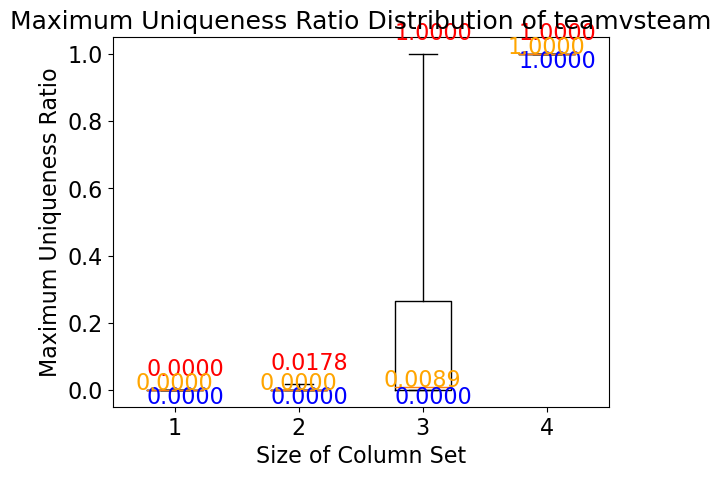

In [16]:
for key, values in l1.items():
    print(f"Table: {key}\nColumns: {values}")
    plt_box(database="hockey", table_name=key, columns=values)

# Top-5 keys table

In [17]:
from itertools import chain, combinations

def get_subkeys(key):
    # 生成所有可能的子键（子集）
    subkeys = chain.from_iterable(combinations(key, r) for r in range(1, len(key)+1))
    return set(subkeys)

def top_5_keys(database, table_name, columns):
    global lengths, avg_times
    total_time = []
    table_data = []

    detailed_output, avg_times, lengths = calculation('root', 'yzh_20010315', database, table_name, columns)
    total_time.append(avg_times)

    # Convert all Decimal to float
    for level, entries in detailed_output.items():
        for idx, (column_combo, ur, cr,  time) in enumerate(entries):
            entries[idx] = (column_combo, float(ur), float(cr), time)

    # # Sort entries within each level by uniqueness ratio in descending order
    sorted_output = [(level, sorted(entries, key=lambda x: x[1], reverse=True)) for level, entries in detailed_output.items()]
    # print(sorted_output)

    # To remember which elements to exclude in future checks
    excluded_elements = set()
    # Processing each level
    
    nk = [] # 存储 ur >= 95% 的数据
    for level, entries in sorted_output:
        # Filter entries to exclude any tuple that contains elements from the excluded_elements set
        top_five_ratios = sorted(set([entry[1] for entry in entries]), reverse=True)[:5]
        filtered_entries = []
        for entry in entries:
            subkeys = get_subkeys(entry[0])
            # if entry[1] in top_five_ratios and entry[1] >= 0.95 and not subkeys.intersection(excluded_elements):
            if entry[1] in top_five_ratios and not subkeys.intersection(excluded_elements):
                filtered_entries.append(entry)

        # Updating the excluded elements if any tuple has a uniqueness ratio of 1.0
        
        for combo, ur, cr, exec_time in filtered_entries:
            if ur == 1.0:
                excluded_elements.add(combo)
            if ur > 0.95:
                nk.append([combo, ur, cr])
                
        # Prepare the table data entry
        # Select the top 5 or less if fewer entries available
        table_data.append((level, [(combo, ur, cr, exec_time) for combo, ur, cr, exec_time in filtered_entries]))

    # Print or process table_data as needed
    
    for entry in table_data:
        if len(entry[1]) != 0:
            print(f"Column Count: {entry[0]}")
            # 创建表格
            table = PrettyTable()
            table.field_names = ["Top-5 Keys", "UR", "CR", "Time"]
            for combo, ur, cr, exec_time in entry[1]:
                table.add_row([', '.join(combo), f'{ur:.4f}', f'{cr:.4f}', f'{exec_time:.4f}'])
                # print(f"{', '.join(combo)} & {ur:.4} \\\\")
            print(table)
            print()
            
    print("Near-Keys (UR >= 95%): ")
    table2 = PrettyTable()
    table2.field_names = ["Keys", "UR", "CR"]
    

    for n in nk:
        table2.add_row([', '.join(c for c in n[0]), f'{n[1]:.4f}', f'{n[2]:.4f}'])
    print(table2)
    
    return nk
     


In [18]:
nk_dic = {}
for key, values in l1.items():
    print("---------------------------------------------------------------------------------------------------------\n")
    print(f"Table: {key}\nColumns: {values}\n")
    nks = top_5_keys(database="hockey", table_name=key, columns=values)
    nk_dic[key] = nks

---------------------------------------------------------------------------------------------------------

Table: abbrev
Columns: ['Type', 'Code', 'Fullname']

Column Count: 1
+------------+--------+--------+--------+
| Top-5 Keys |   UR   |   CR   |  Time  |
+------------+--------+--------+--------+
|  Fullname  | 1.0000 | 1.0000 | 0.0002 |
|    Code    | 0.6552 | 1.0000 | 0.0002 |
|    Type    | 0.0000 | 1.0000 | 0.0005 |
+------------+--------+--------+--------+

Column Count: 2
+------------+--------+--------+--------+
| Top-5 Keys |   UR   |   CR   |  Time  |
+------------+--------+--------+--------+
| Type, Code | 1.0000 | 1.0000 | 0.0002 |
+------------+--------+--------+--------+

Near-Keys (UR >= 95%): 
+------------+--------+--------+
|    Keys    |   UR   |   CR   |
+------------+--------+--------+
|  Fullname  | 1.0000 | 1.0000 |
| Type, Code | 1.0000 | 1.0000 |
+------------+--------+--------+
--------------------------------------------------------------------------------

# Degree of violation distribution

In [19]:
import numpy as np


def degree_of_violation(cursor, table_name, columns):
    if not columns:
        return 0, 0
    query = f"""
        SELECT {', '.join([f"`{col}`" for col in columns])}, COUNT(*) AS group_count 
        FROM `{table_name}` 
        WHERE {' AND '.join([f"`{col}` IS NOT NULL" for col in columns])}
        GROUP BY {', '.join([f"`{col}`" for col in columns])}
        HAVING COUNT(*) > 1;
    """
    query2 = f"""
        SELECT ss.*, group_count
        FROM (
            SELECT {', '.join([f"`{col}`" for col in columns])}, COUNT(*) AS group_count
            FROM {table_name}
            GROUP BY {', '.join([f"`{col}`" for col in columns])}
            HAVING COUNT(*) > 1
        ) dup
        JOIN `{table_name}` ss ON {' AND '.join([f"ss.`{col}` IS NOT NULL" for col in columns])} AND {' AND '.join([f"dup.`{col}` IS NOT NULL" for col in columns])} AND {' AND '.join([f"ss.`{col}` = dup.`{col}`" for col in columns])};
    """
    cursor.execute(query2)
    group_table = cursor.fetchall()
    # print(query2)
    
    # print(group_table)
    return group_table



def main_degree(database, table_name, columns):
    try:
        connection = mysql.connector.connect(user = "root", password = "yzh_20010315", database = database)

        if connection.is_connected():
            cursor = connection.cursor()
            group_table = degree_of_violation(cursor, table_name, columns)
            # print(group_table)
            duplicate_dic = {}
            for item in group_table:
                key = item[-1]
                value = item[:-1]
                if key in duplicate_dic:
                    duplicate_dic[key].append(list(value))
                else:
                    duplicate_dic[key] = [list(value)]
            # print("group_table: ", group_table)
            
            # 准备数据
            x = list(duplicate_dic.keys())
            y = [int(len(value) / key) for key, value in duplicate_dic.items()]
            # print(x, "\n", y)
            
            if len(x) != 1:
                # Ensure x and y are sorted by x
                sorted_data = sorted(zip(x, y))
                x, y = zip(*sorted_data)
                
                # Create the bar chart
                colors = plt.cm.Paired.colors[:len(x)]
                plt.figure(figsize=(10, 5))
                plt.bar(x, y, color=colors, alpha=0.7)
                
                # Use logarithmic scale for y-axis
                plt.yscale('log')
                
                # Set custom tick positions for better readability
                y_ticks = np.logspace(0, np.ceil(np.log10(max(y))), num=10, base=10.0)
                plt.yticks(y_ticks, [f"{int(tick)}" for tick in y_ticks])
                
                # Display values on top of each bar
                for i in range(len(x)):
                    plt.text(x[i], y[i], f'{y[i]}', fontsize=16, ha='center', va='bottom')
                
                # Set labels and title
                plt.xlabel('Degree of Violation')
                plt.ylabel('Number')
                # plt.title(f"Duplicate Distribution for Near-Key {columns}")
                
                # Show the chart
                plt.show()

                
                # # 绘制折线图
                # plt.plot(x, y, color='blue', linestyle='-', marker='x')
                # 
                # # 在每个数据点上显示数值
                # for i in range(len(x)):
                #     plt.text(x[i], y[i], f'{y[i]}', fontsize=9, ha='right')
                # 
                # # 设置标签和标题
                # plt.xlabel('Degree of Violation')
                # plt.ylabel('Number')
                # plt.title(f" Duplicate Distribution for Near-Key {columns}")
                

            else:
                 print(f"There are {y[0]} entities in this table which the degree of violation is {x[0]}.\n")
            
            all_col = get_column_names(cursor, table_name)
            for num in range(len(all_col)):
                if all_col[num] in columns:
                    all_col[num] = "** " + all_col[num] + " **"
            all_col.insert(0, ' ')
            for key, value in duplicate_dic.items():
                print(f"Degree of Duplication: {key}")
                table_dup = PrettyTable()
                table_dup.field_names = all_col

                for idx, v in enumerate(value, start=1):
                    row = [idx] + v
                    table_dup.add_row(row)

                # print(table_dup)
                print()

    except Error as e:
        print("Error:", e)
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()



==================== Table: awardsplayers; Near-key: ('playerID', 'year', 'pos') ====================

There are 6 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



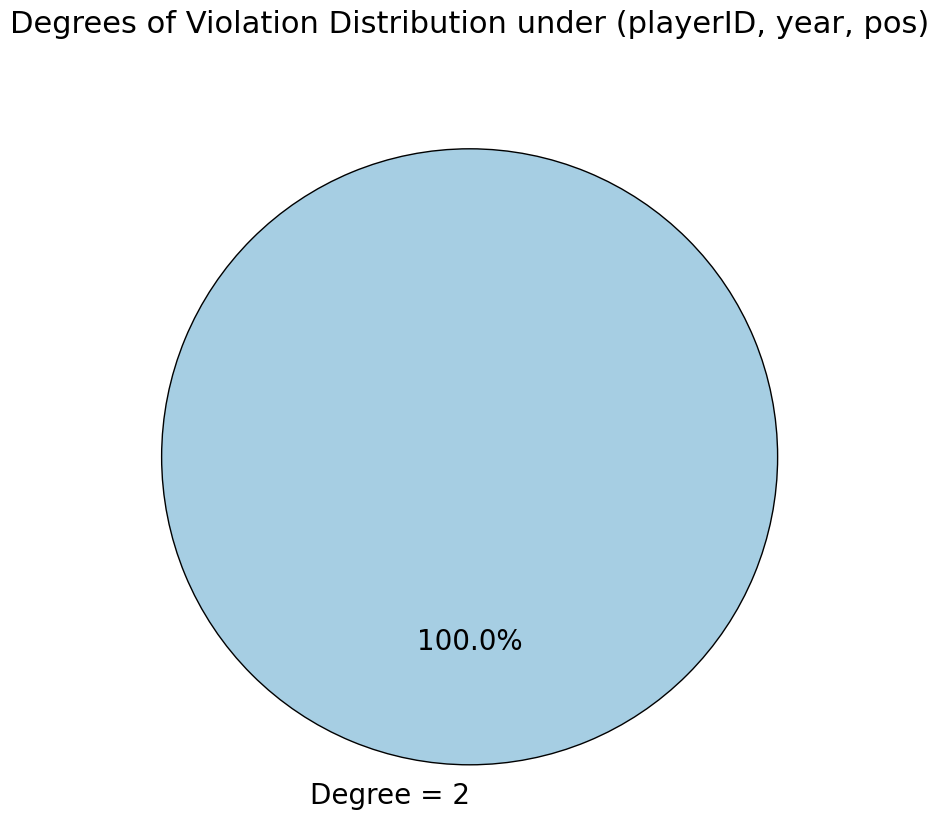


==================== Table: awardsplayers; Near-key: ('playerID', 'year', 'lgID', 'pos') ====================

There are 6 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



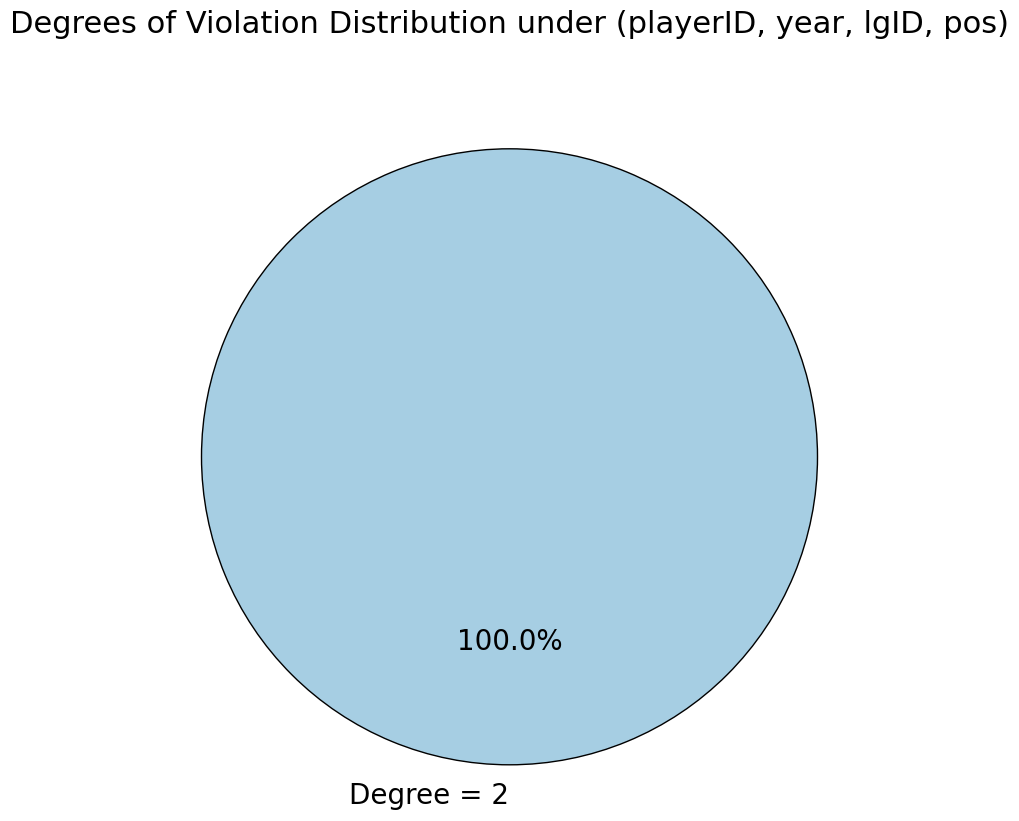


==================== Table: coaches; Near-key: ('coachID', 'year') ====================

There are 14 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



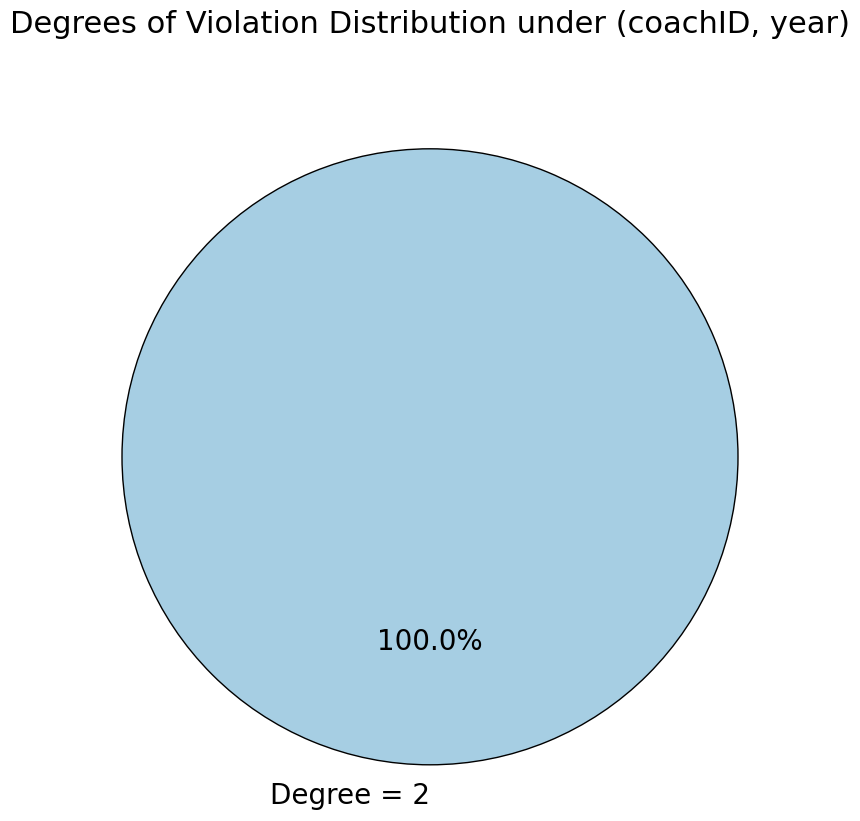


==================== Table: coaches; Near-key: ('year', 'tmID', 'stint') ====================

There are 1 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



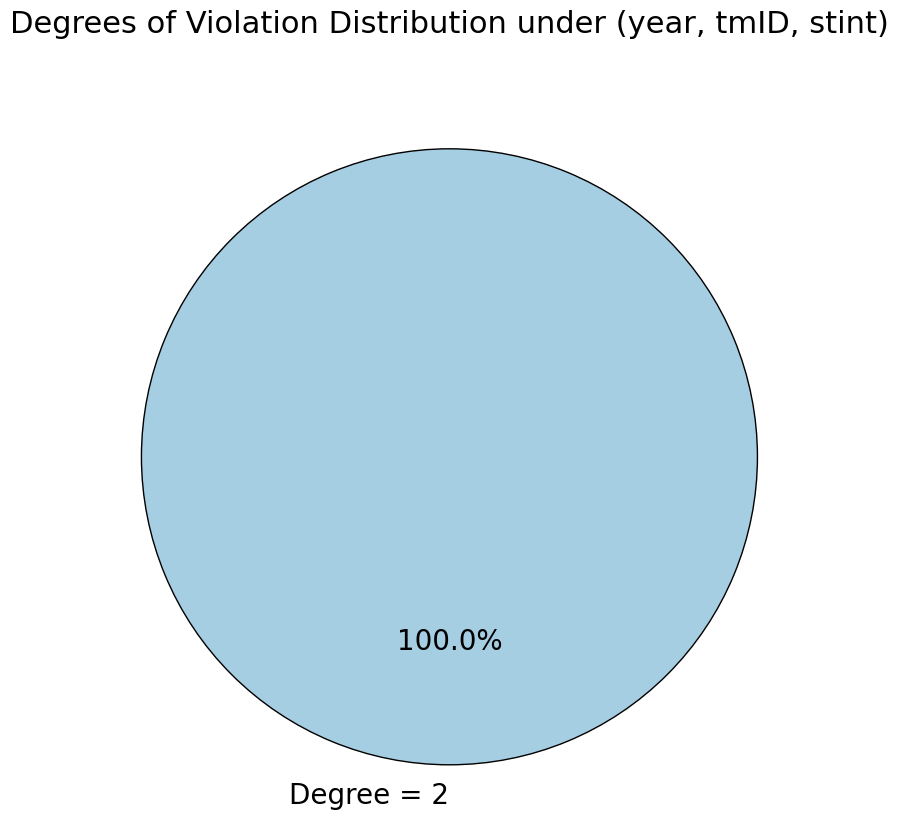


==================== Table: coaches; Near-key: ('coachID', 'year', 'tmID') ====================

There are 5 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



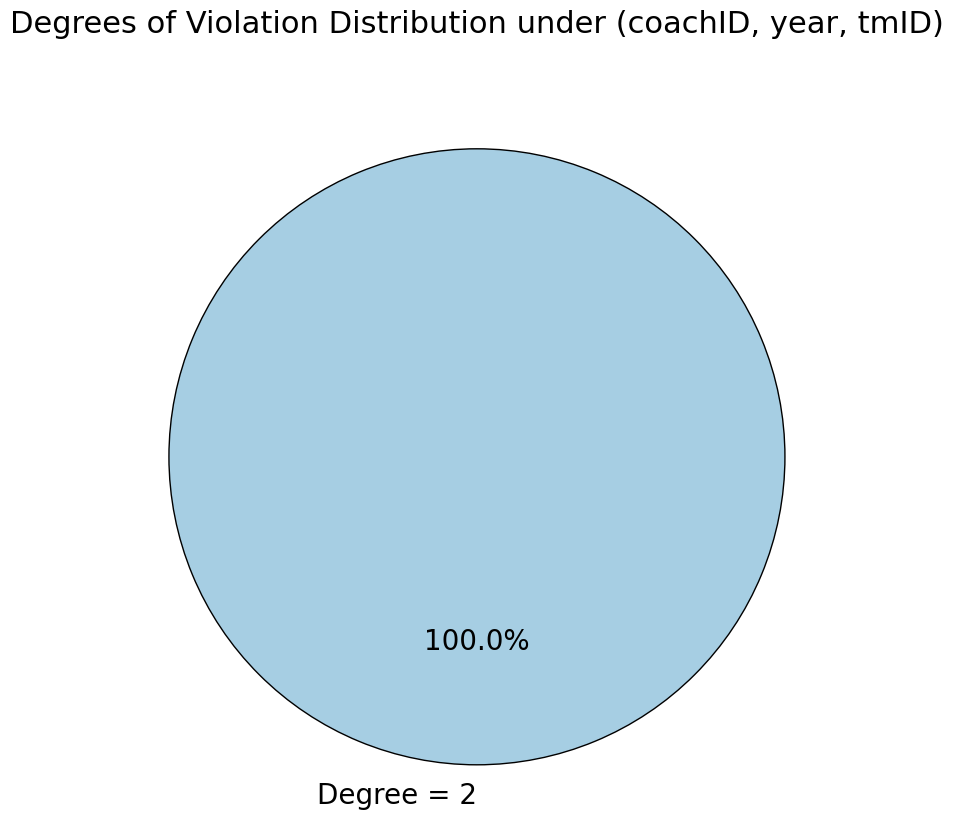


==================== Table: coaches; Near-key: ('coachID', 'year', 'lgID') ====================

There are 14 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



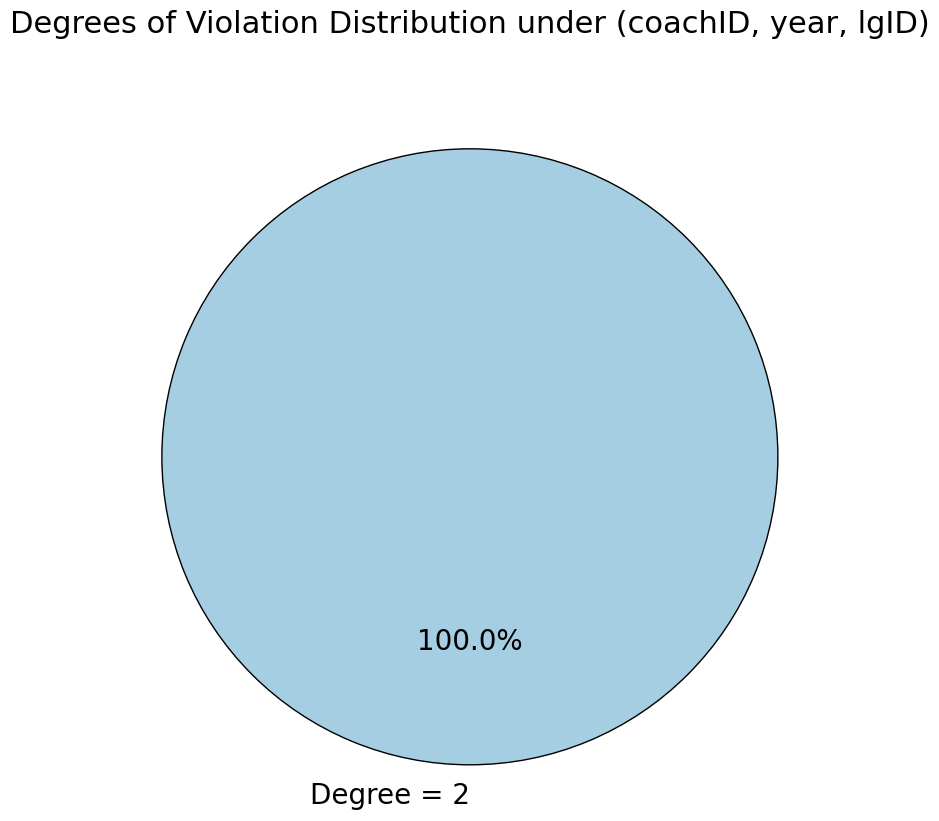


==================== Table: coaches; Near-key: ('year', 'tmID', 'lgID', 'stint') ====================

There are 1 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



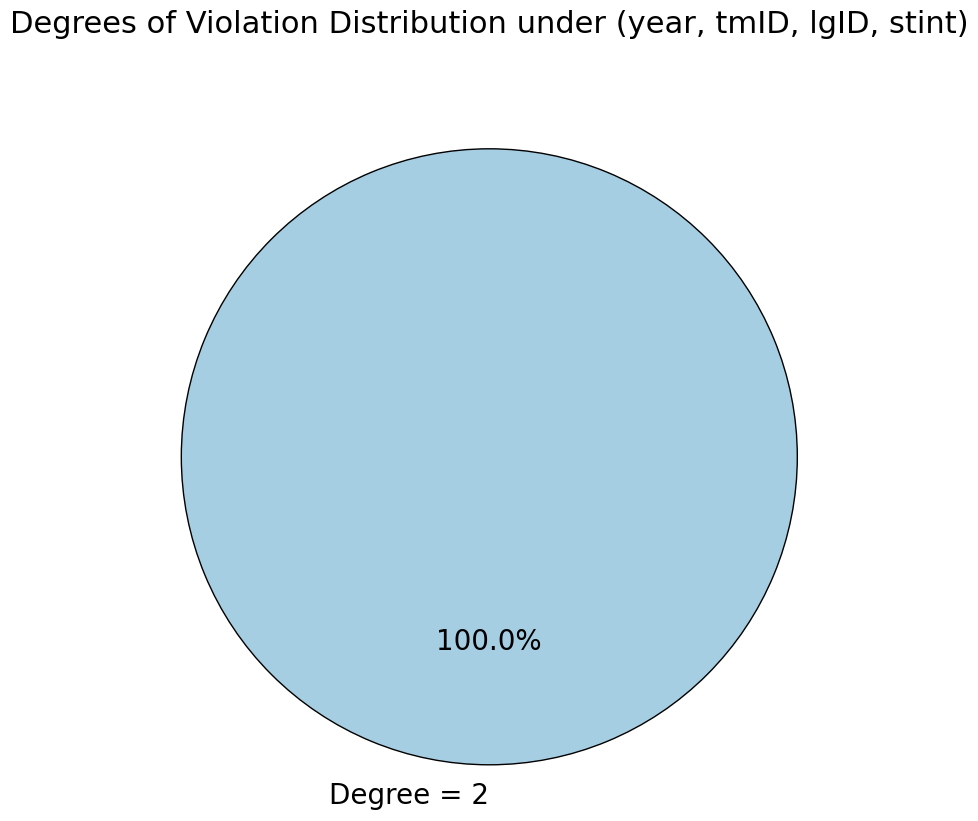


==================== Table: coaches; Near-key: ('coachID', 'year', 'tmID', 'lgID') ====================

There are 5 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



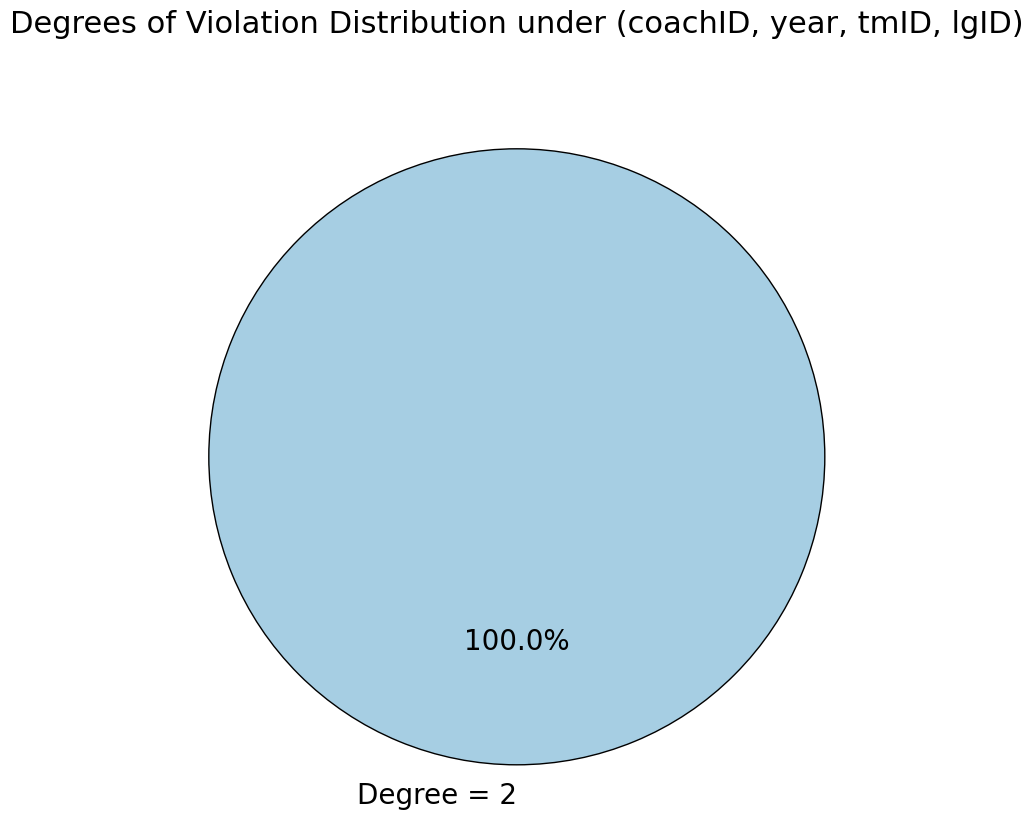


==================== Table: combinedshutouts; Near-key: ('month', 'IDgoalie1') ====================

There are 1 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



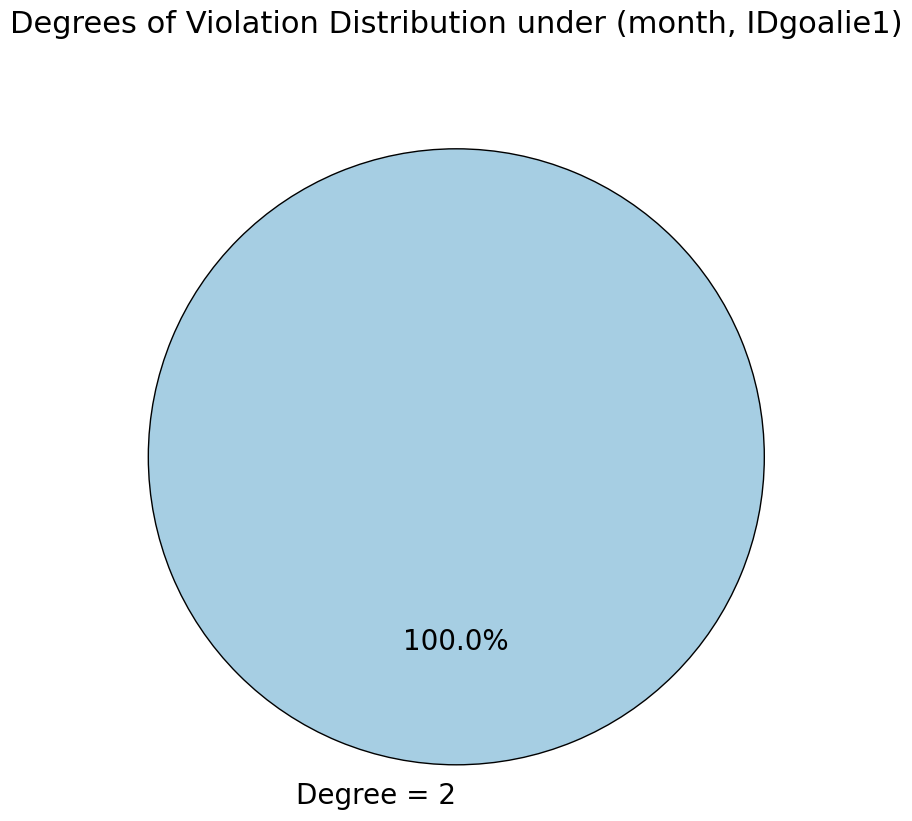


==================== Table: combinedshutouts; Near-key: ('month', 'IDgoalie2') ====================

There are 1 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



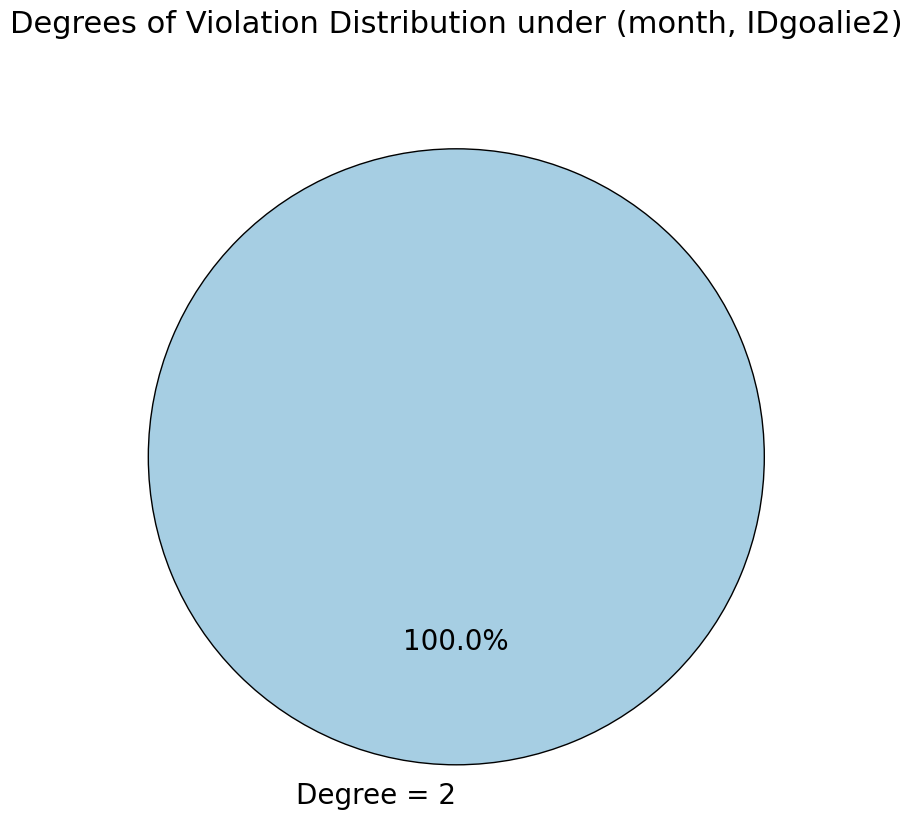


==================== Table: combinedshutouts; Near-key: ('tmID', 'oppID') ====================

There are 1 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



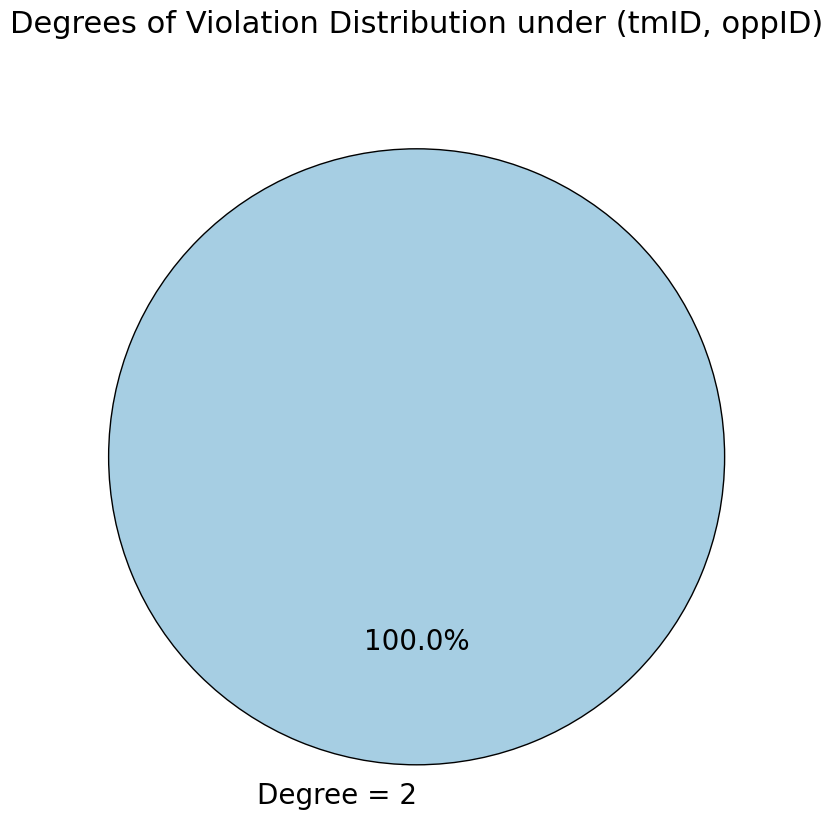


==================== Table: combinedshutouts; Near-key: ('oppID', 'IDgoalie1') ====================

There are 1 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



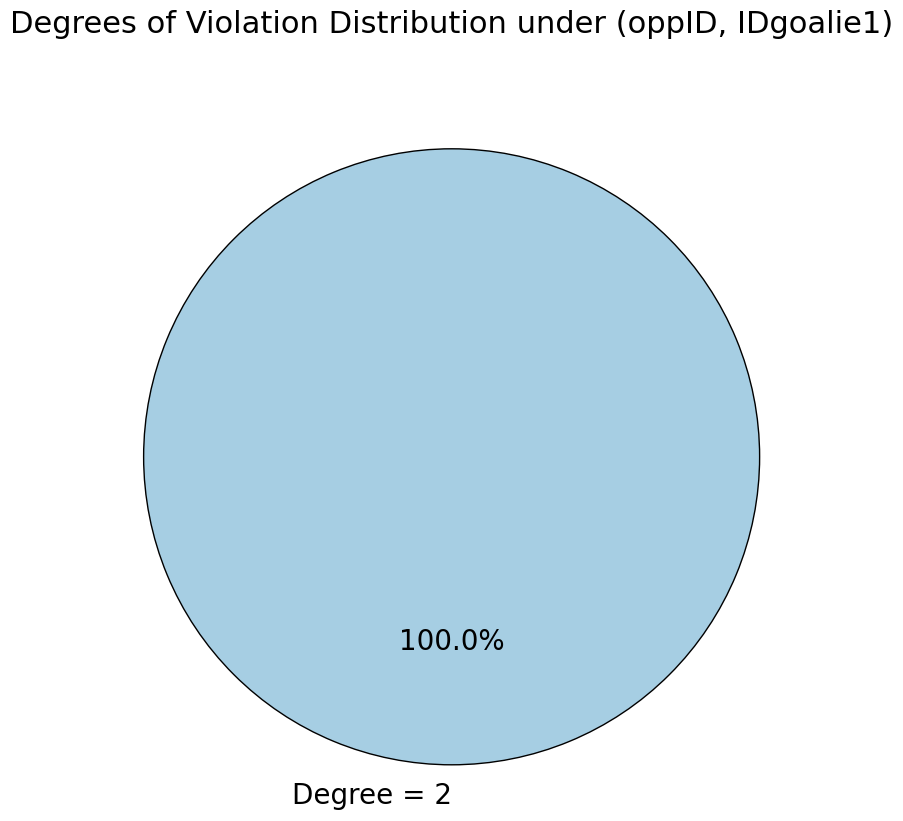


==================== Table: combinedshutouts; Near-key: ('month', 'R/P', 'IDgoalie2') ====================

There are 1 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



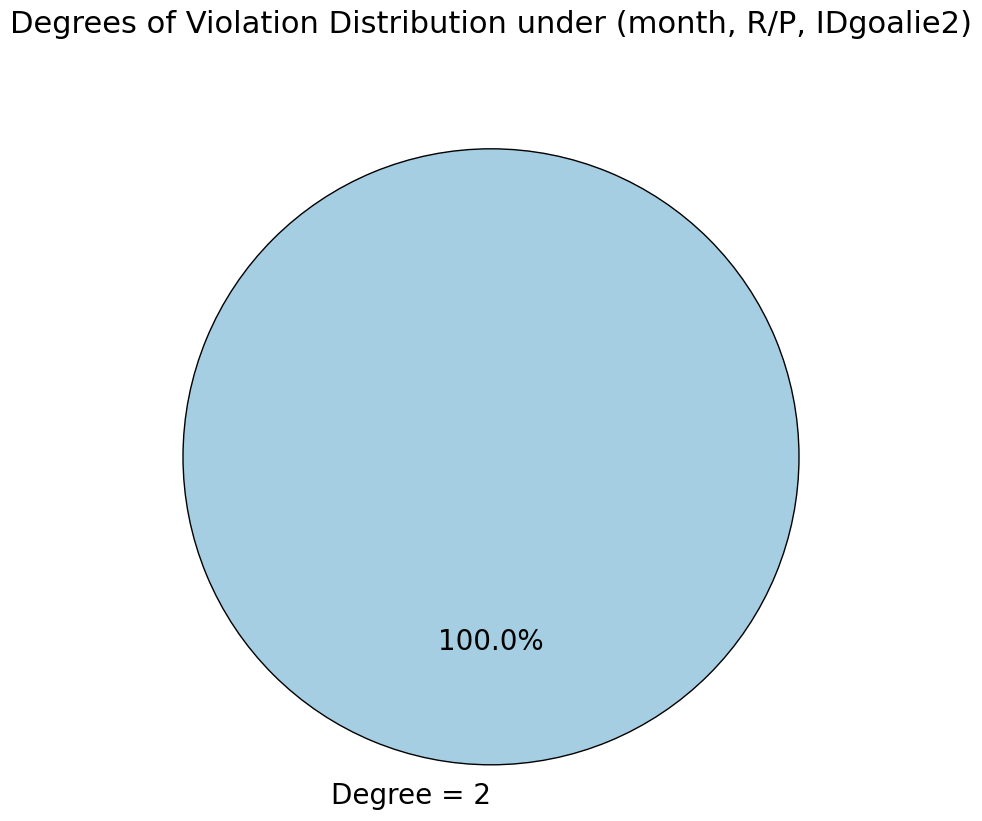


==================== Table: combinedshutouts; Near-key: ('tmID', 'oppID', 'R/P') ====================

There are 1 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



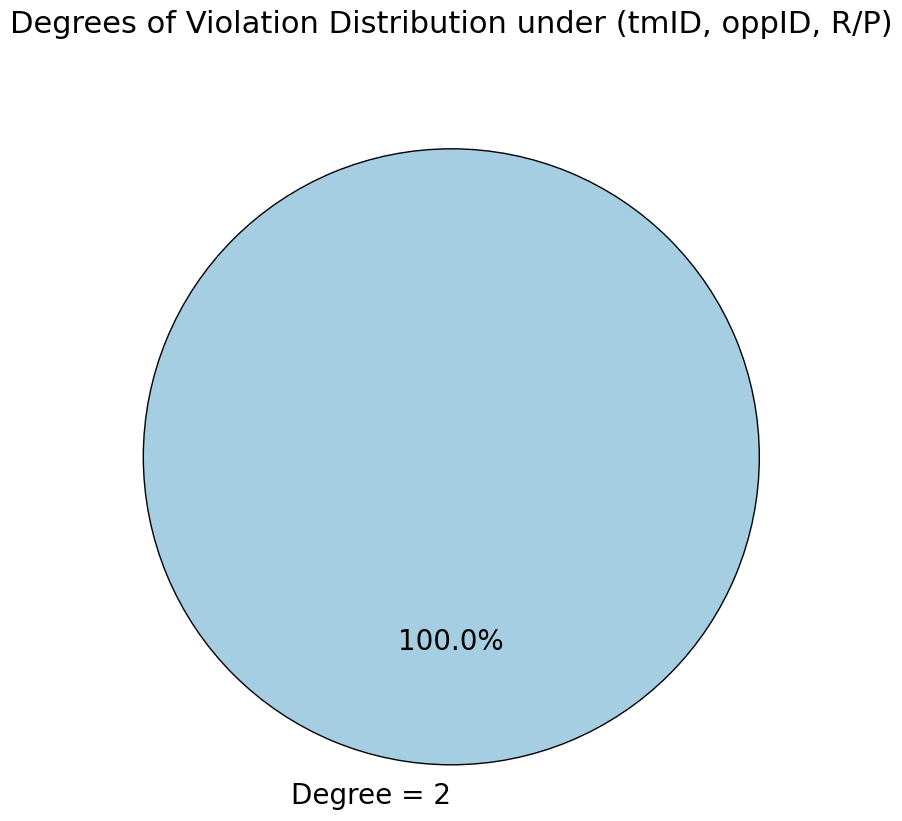


==================== Table: combinedshutouts; Near-key: ('tmID', 'oppID', 'IDgoalie1') ====================

There are 1 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



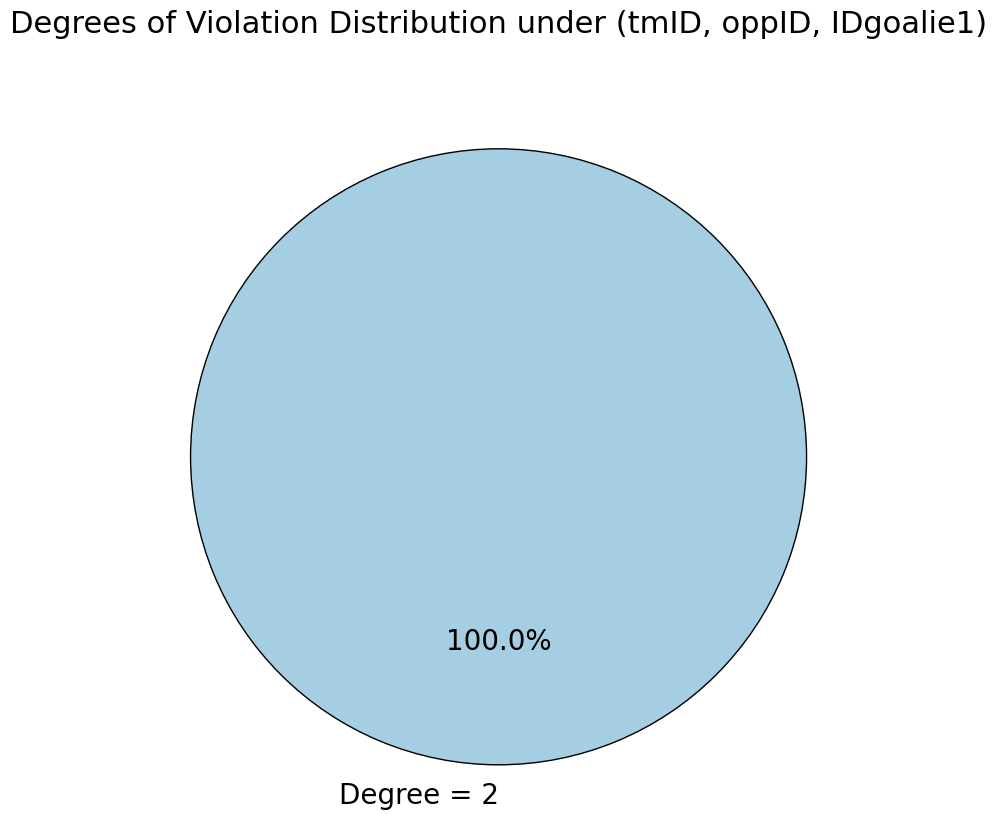


==================== Table: combinedshutouts; Near-key: ('oppID', 'R/P', 'IDgoalie1') ====================

There are 1 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



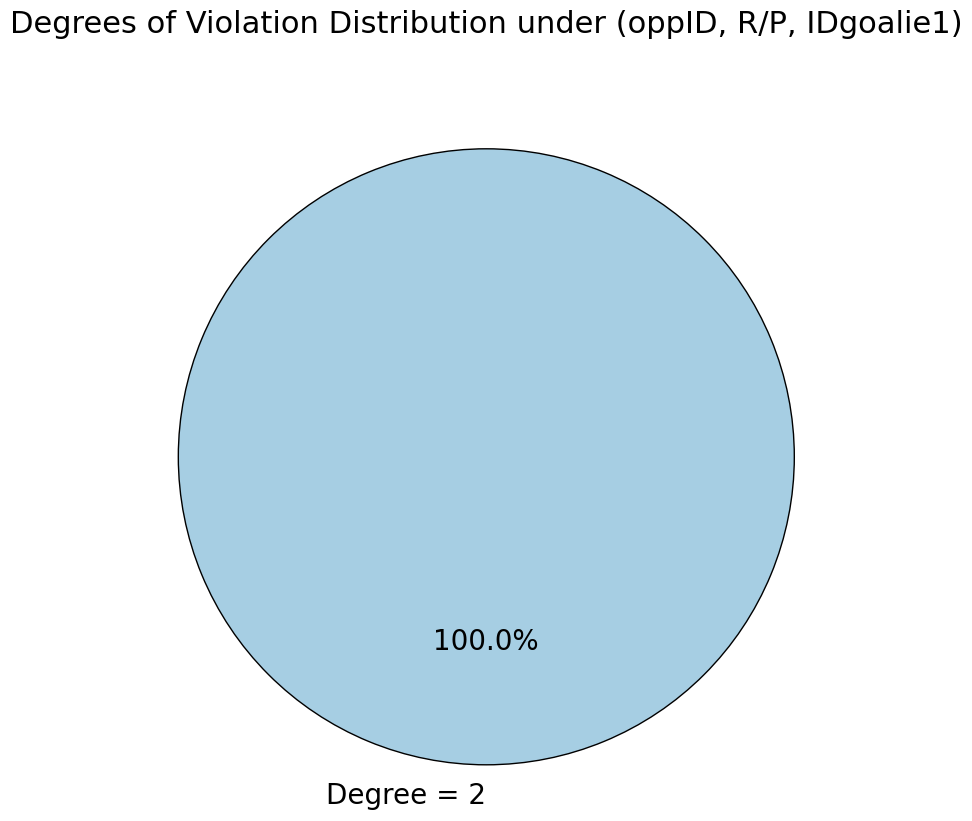


==================== Table: combinedshutouts; Near-key: ('tmID', 'oppID', 'R/P', 'IDgoalie1') ====================

There are 1 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



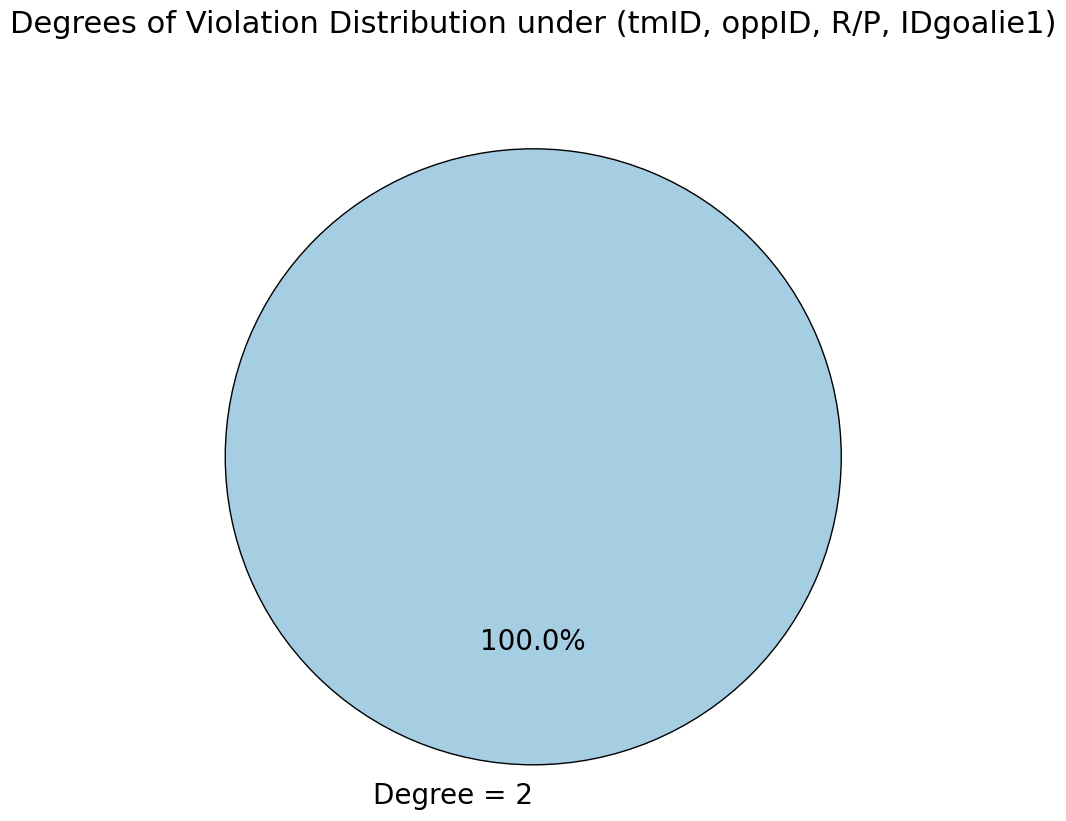


==================== Table: goalies; Near-key: ('playerID', 'year', 'tmID') ====================

There are 1 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



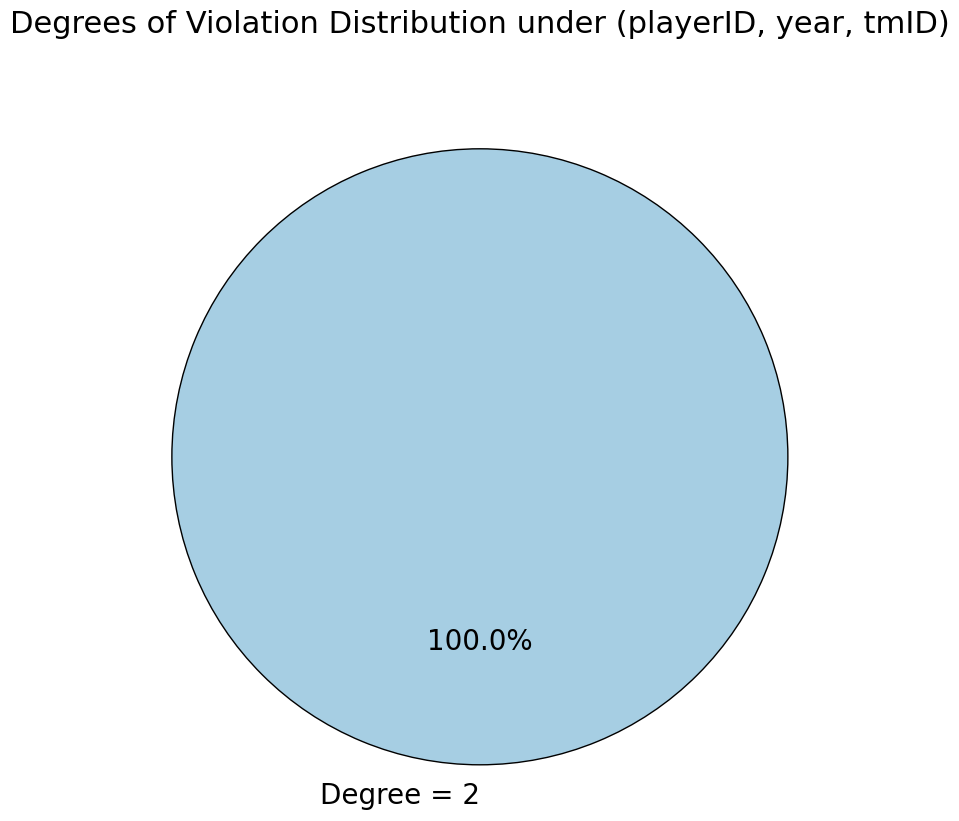


==================== Table: goalies; Near-key: ('playerID', 'year', 'GP') ====================

There are 11 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



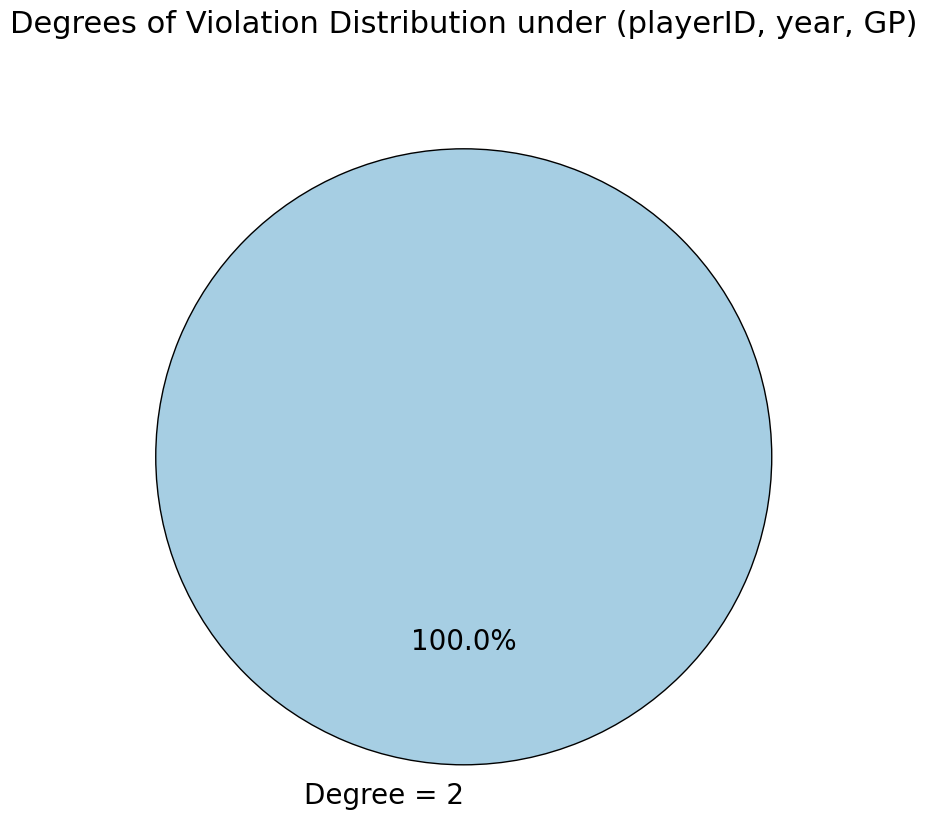


==================== Table: goalies; Near-key: ('year', 'tmID', 'GP') ====================



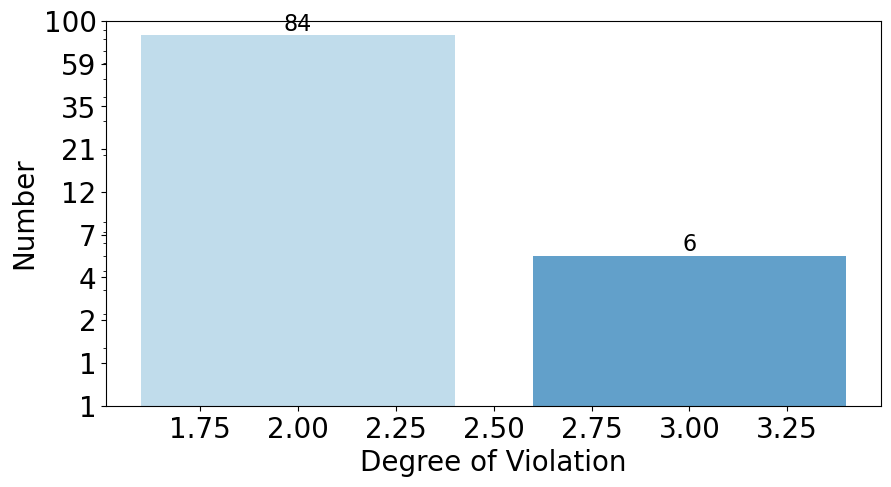

Degree of Duplication: 3

Degree of Duplication: 2



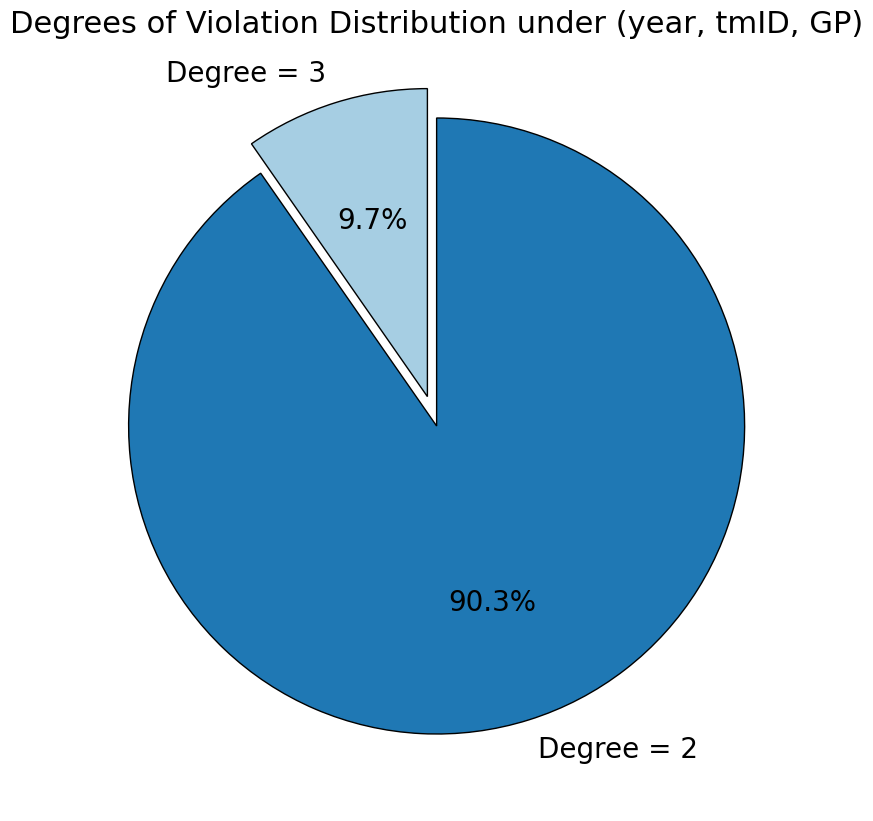


==================== Table: goalies; Near-key: ('playerID', 'year', 'tmID', 'lgID') ====================

There are 1 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



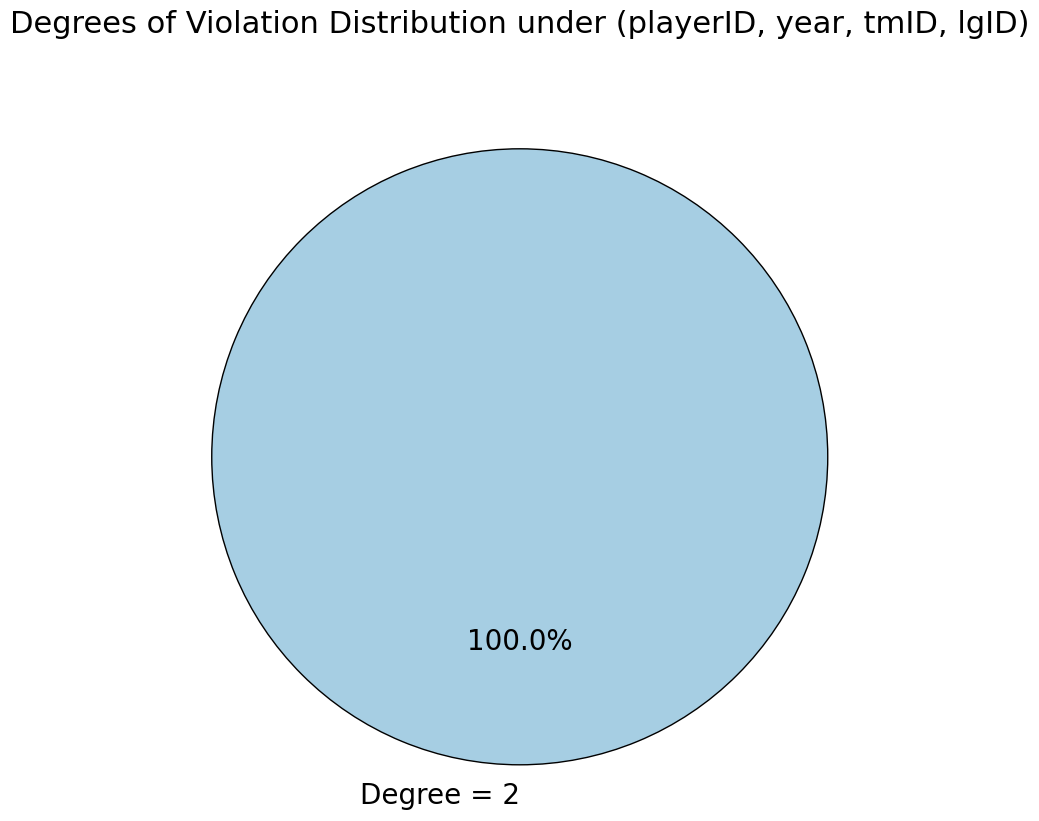


==================== Table: goalies; Near-key: ('playerID', 'year', 'lgID', 'GP') ====================

There are 11 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



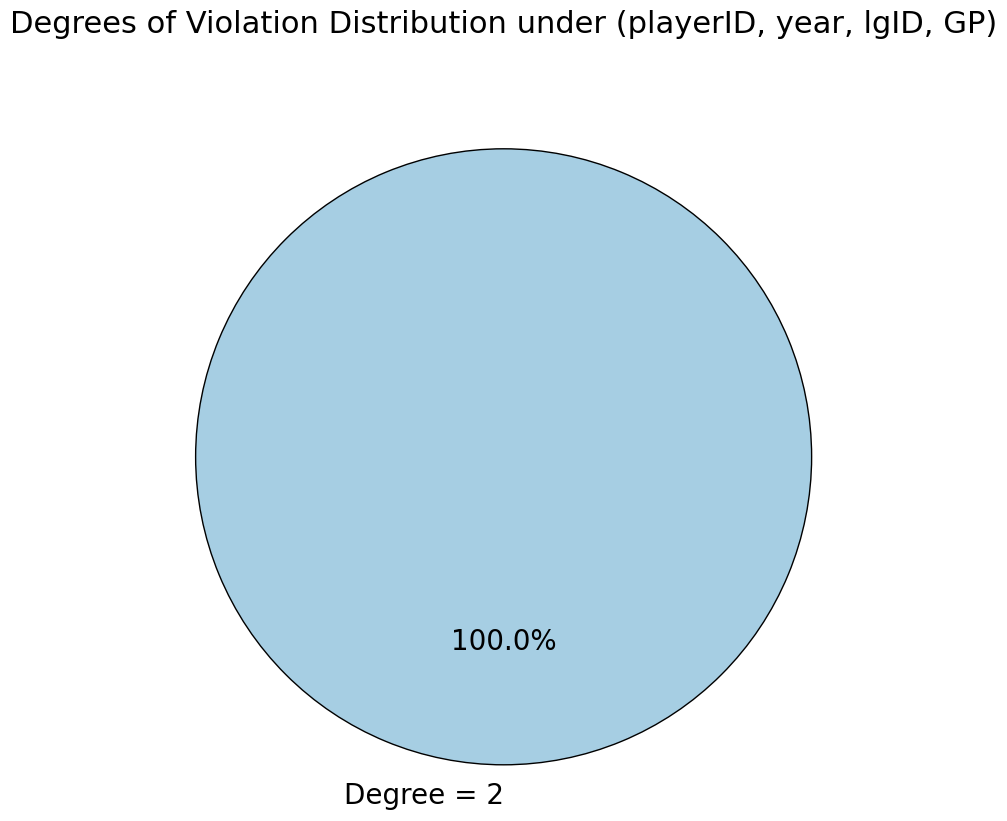


==================== Table: goalies; Near-key: ('year', 'stint', 'tmID', 'GP') ====================



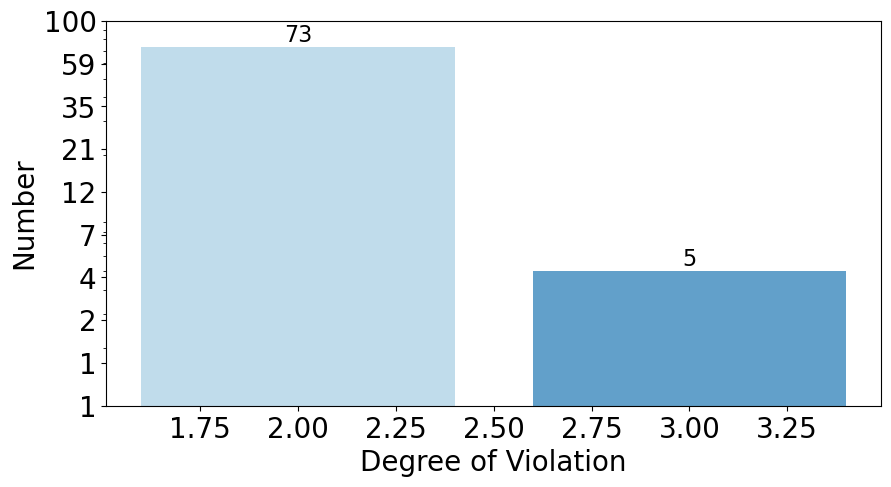

Degree of Duplication: 3

Degree of Duplication: 2



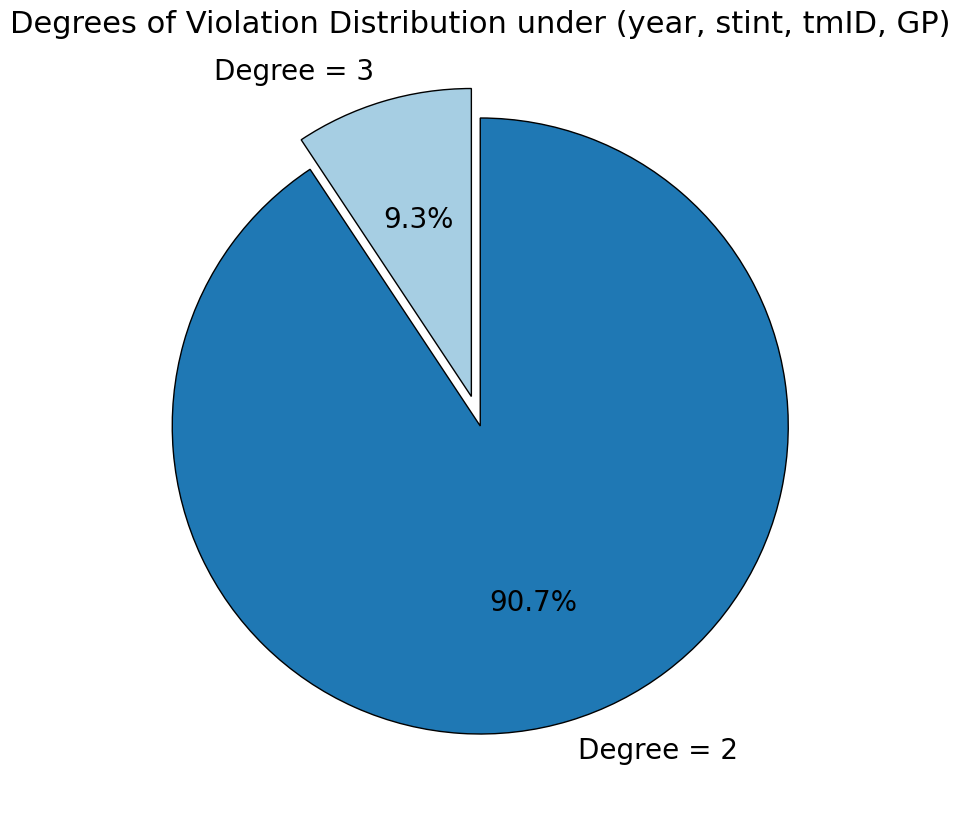


==================== Table: goalies; Near-key: ('year', 'tmID', 'lgID', 'GP') ====================



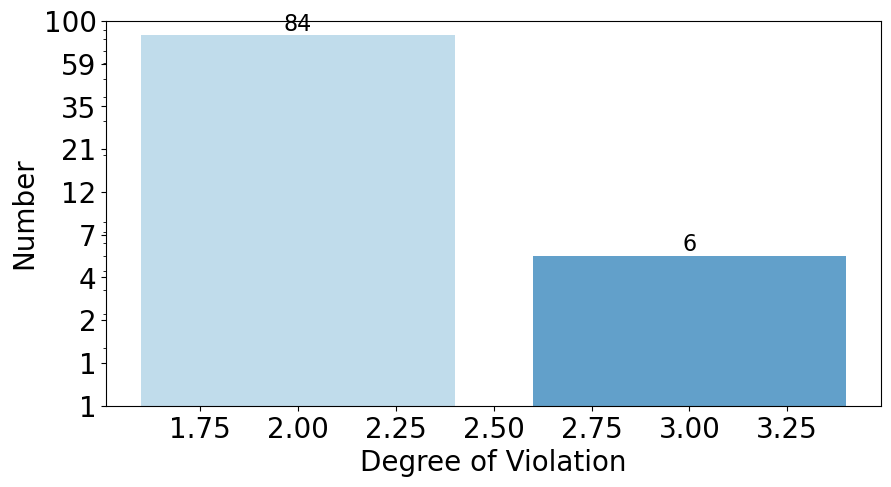

Degree of Duplication: 3

Degree of Duplication: 2



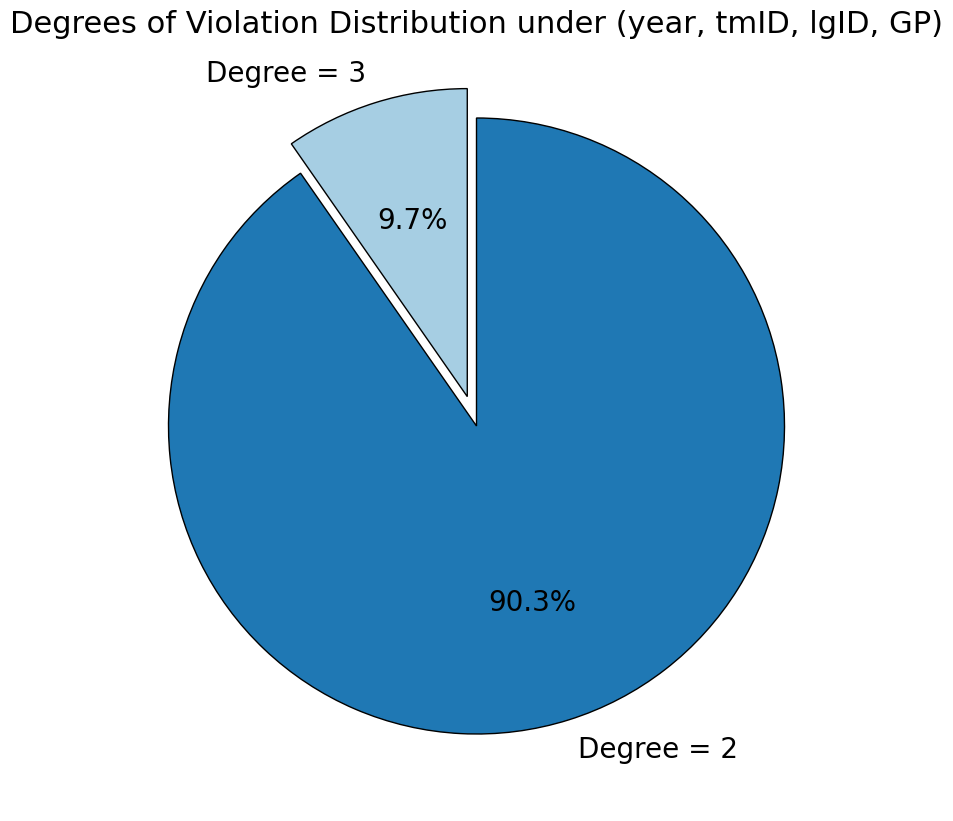


==================== Table: goalies; Near-key: ('year', 'stint', 'tmID', 'lgID', 'GP') ====================



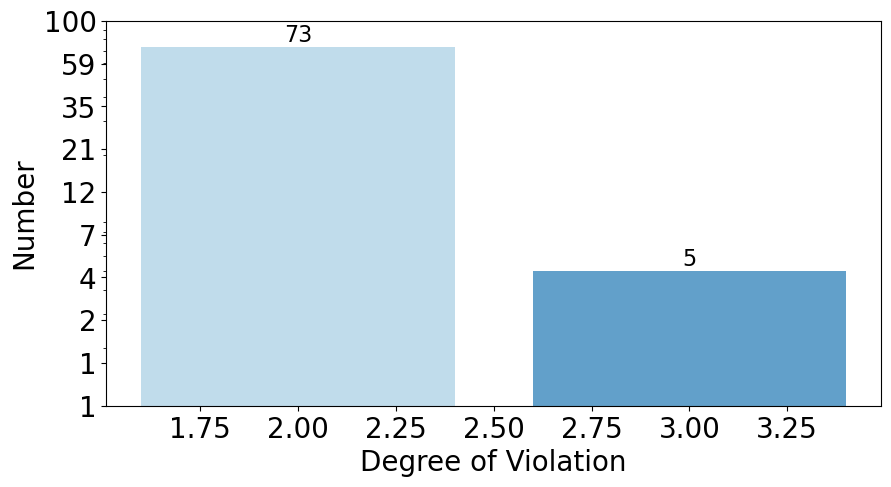

Degree of Duplication: 3

Degree of Duplication: 2



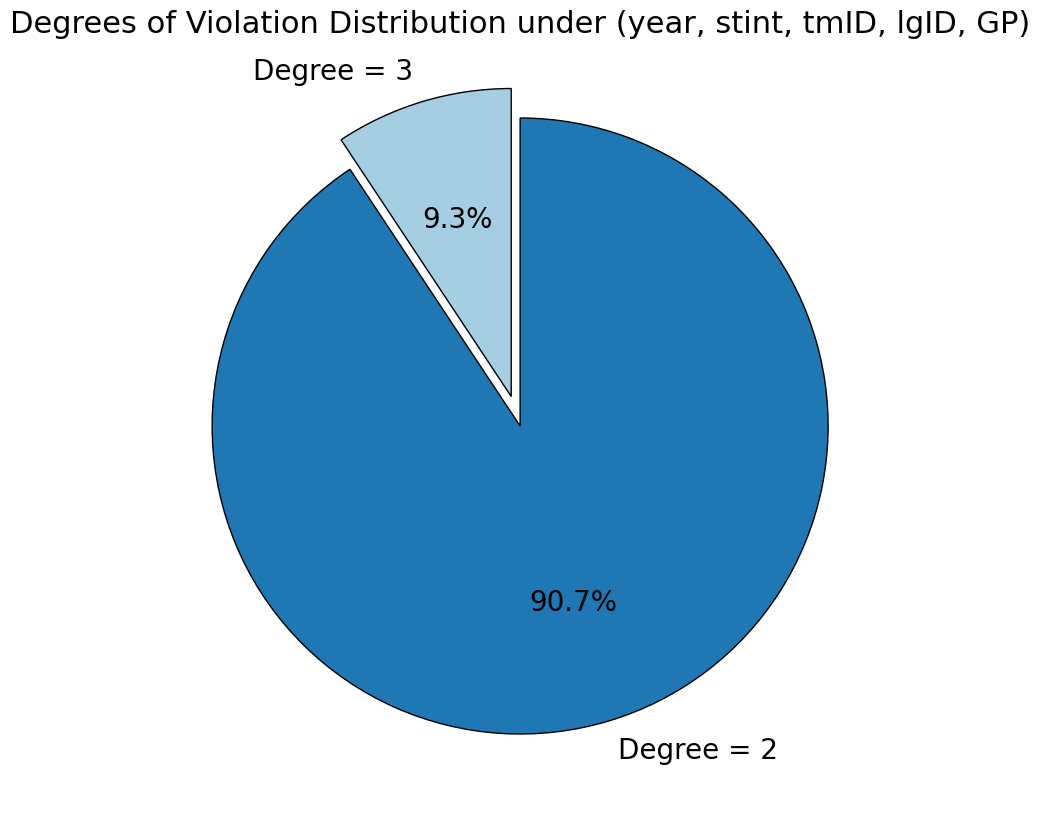


==================== Table: goaliesshootout; Near-key: ('playerID', 'year') ====================

There are 11 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



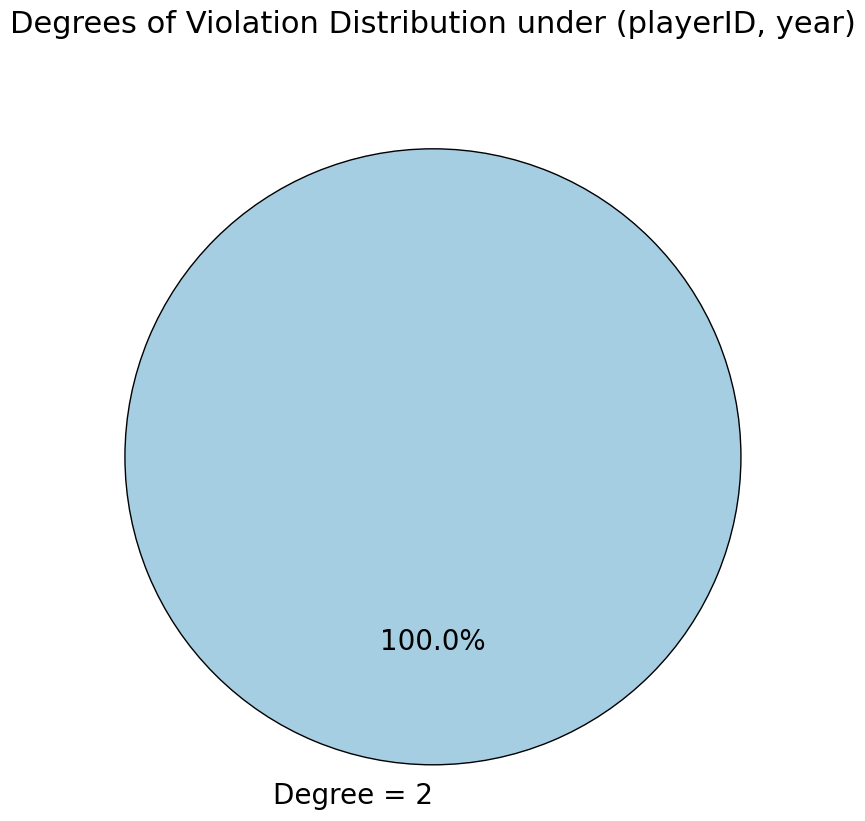


==================== Table: hof; Near-key: ('name',) ====================

There are 1 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



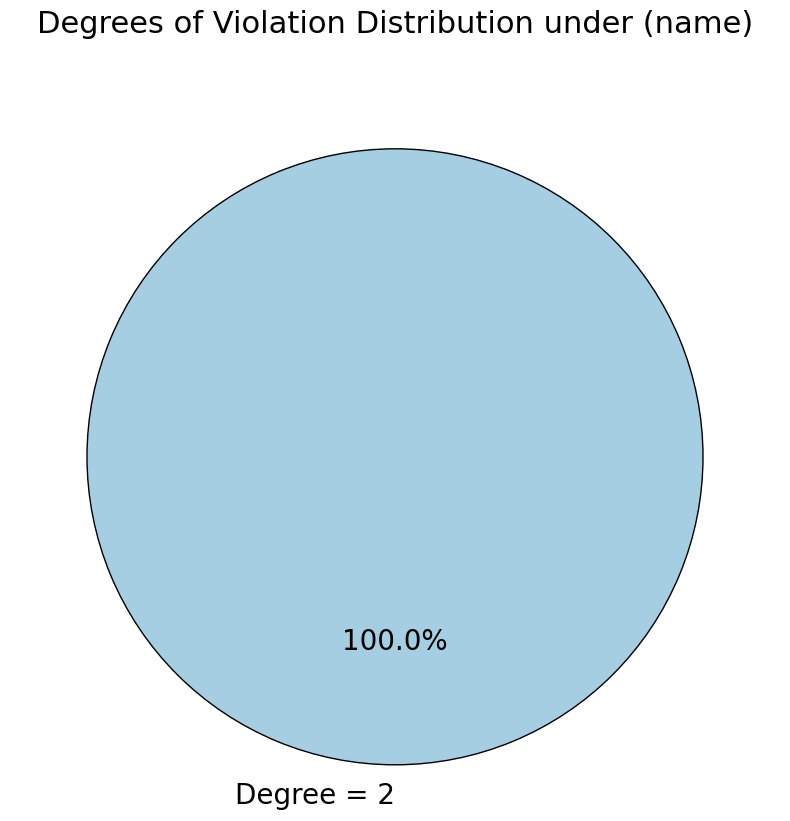


==================== Table: hof; Near-key: ('name', 'category') ====================

There are 1 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



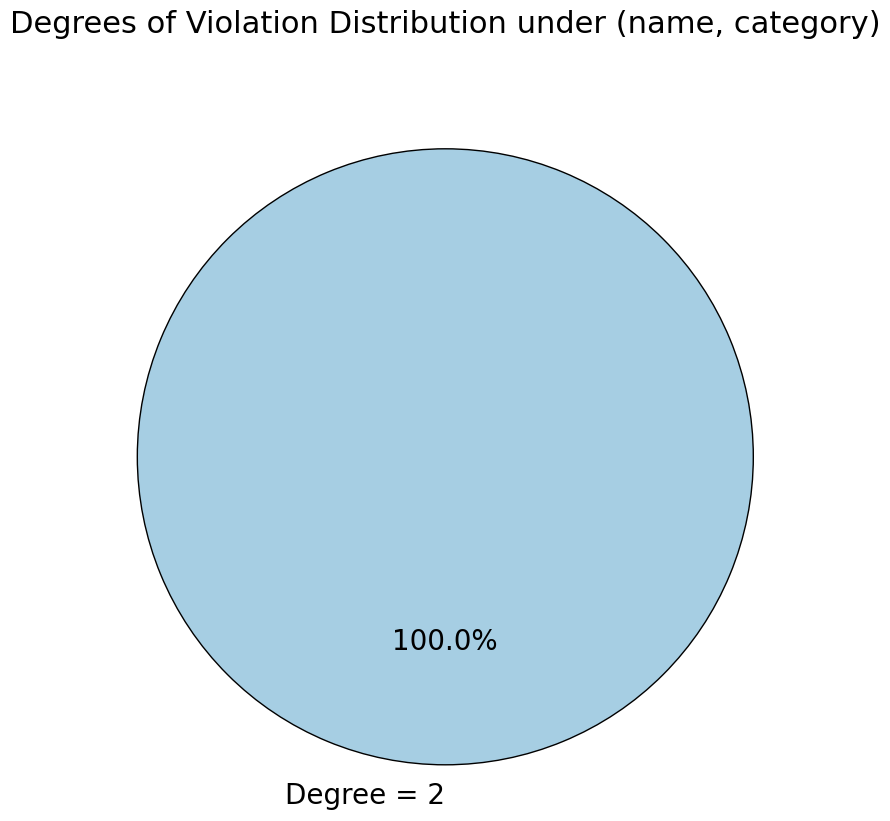


==================== Table: master; Near-key: ('lastName', 'nameGiven') ====================

There are 6 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



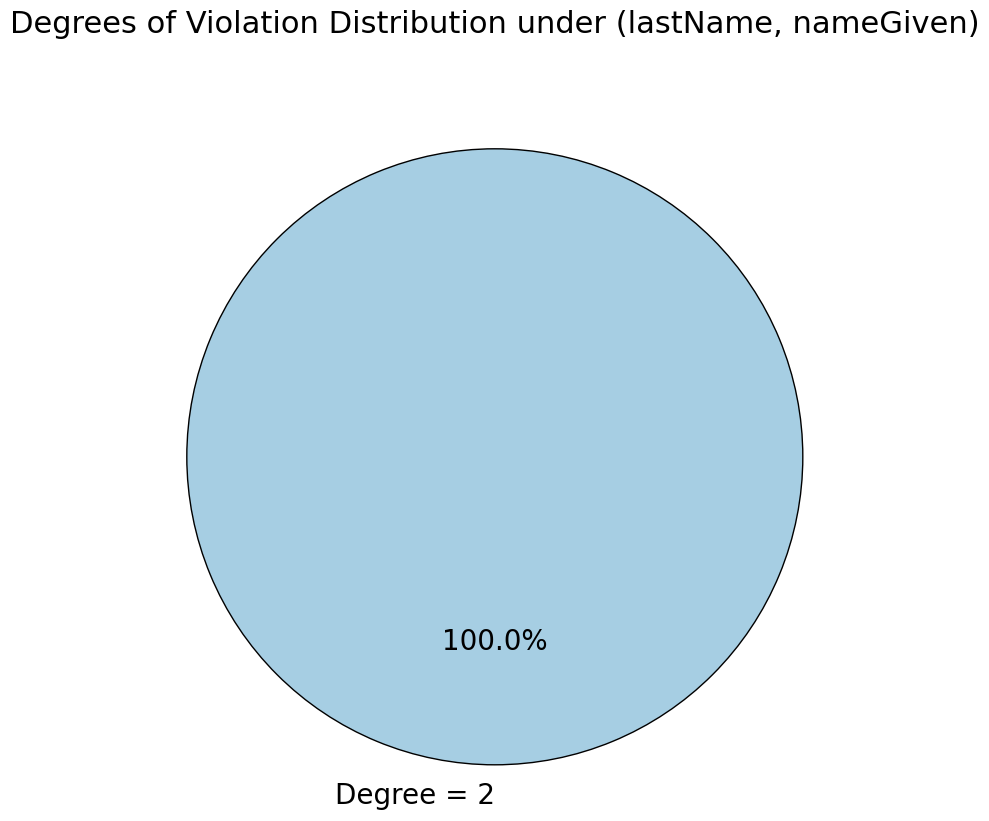


==================== Table: master; Near-key: ('lastName', 'birthYear') ====================



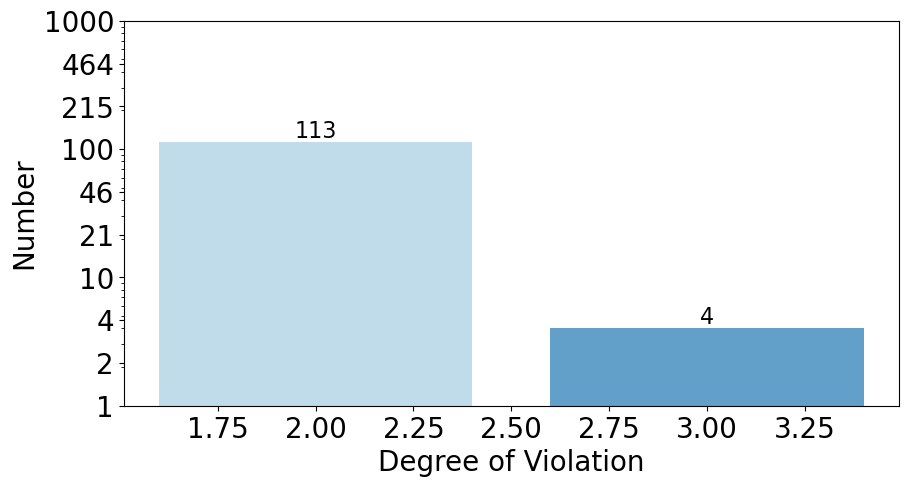

Degree of Duplication: 2

Degree of Duplication: 3



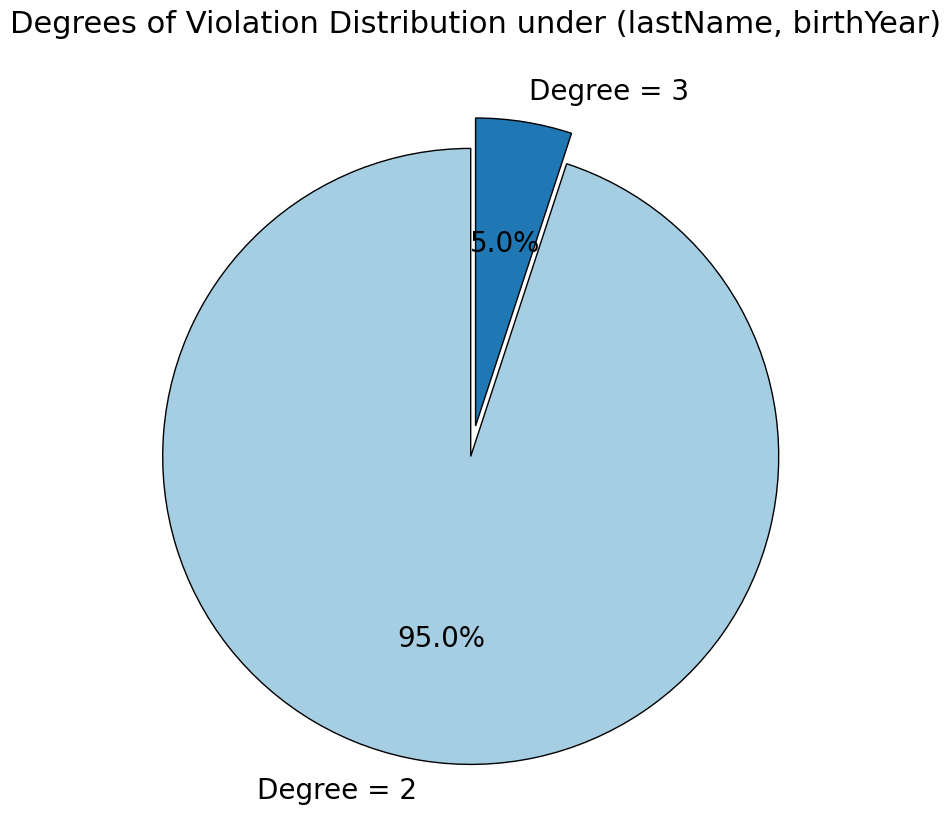


==================== Table: master; Near-key: ('lastName', 'nameGiven', 'pos') ====================

There are 1 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



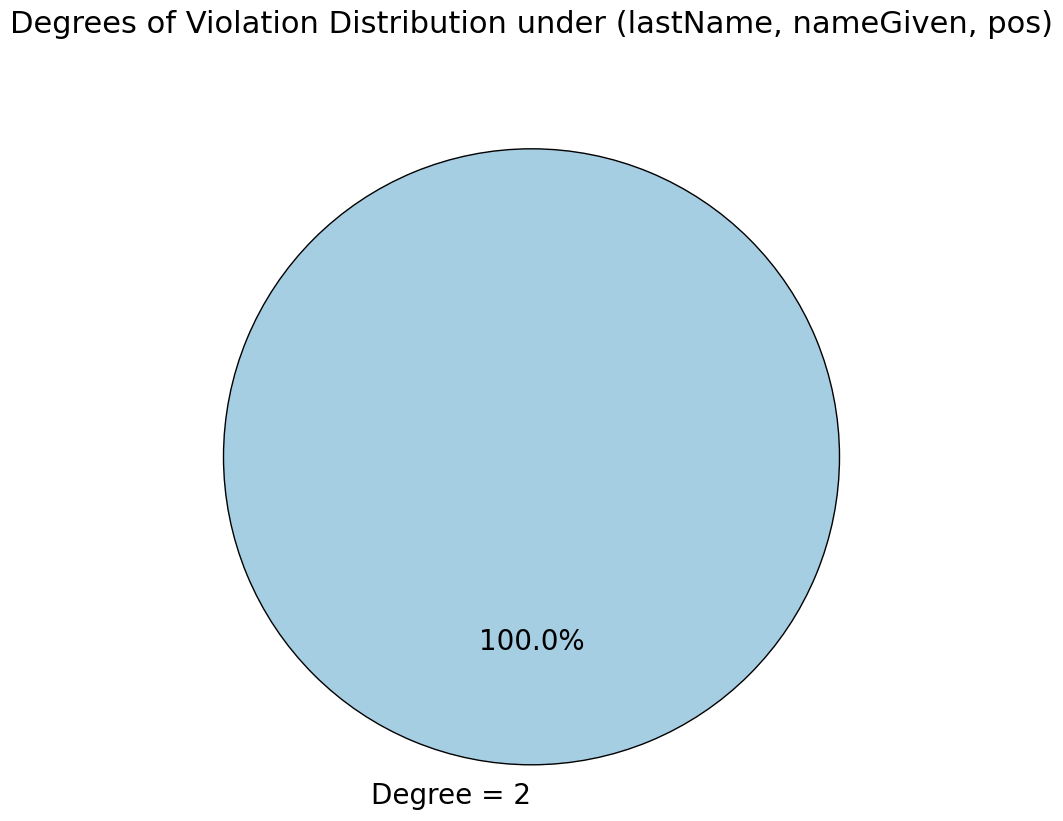


==================== Table: master; Near-key: ('lastName', 'birthYear', 'pos') ====================

There are 23 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



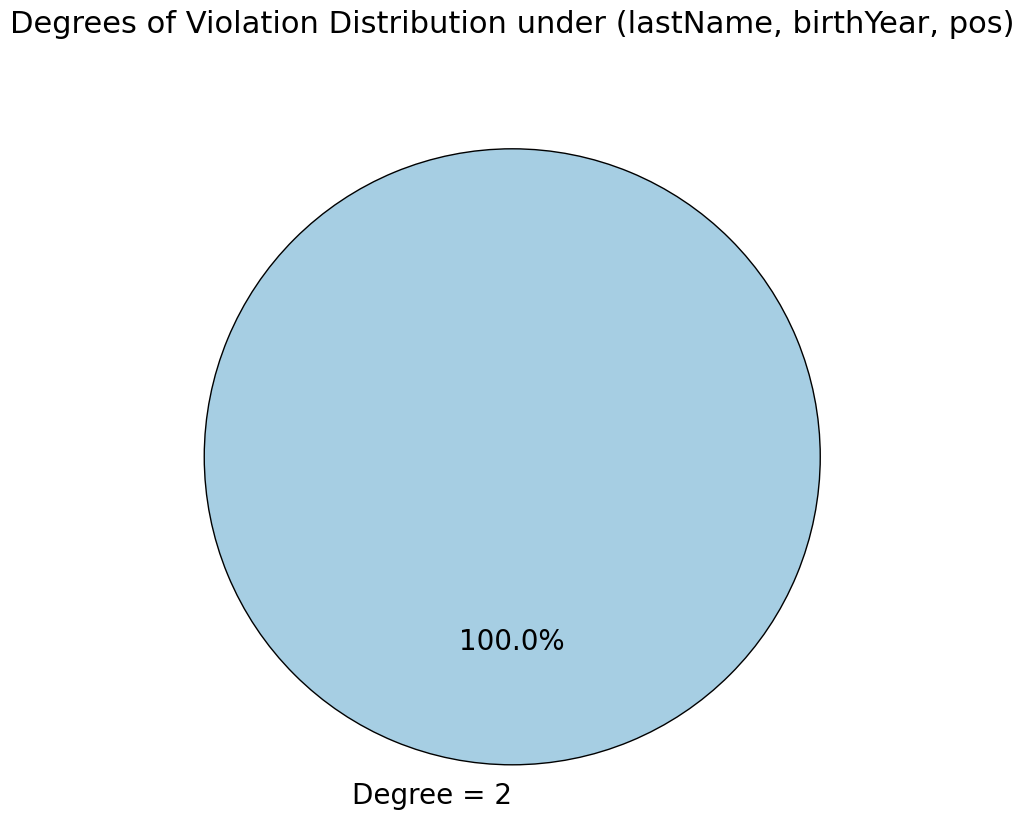


==================== Table: master; Near-key: ('nameGiven', 'birthYear', 'pos') ====================



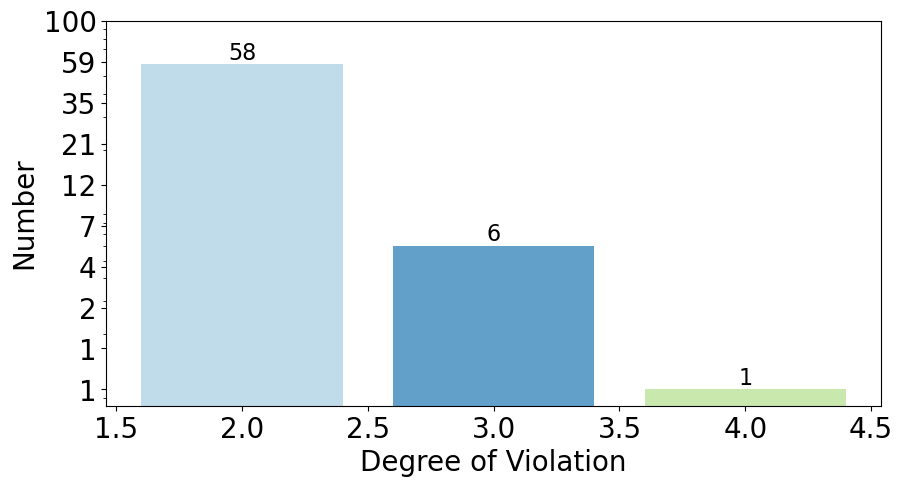

Degree of Duplication: 2

Degree of Duplication: 3

Degree of Duplication: 4



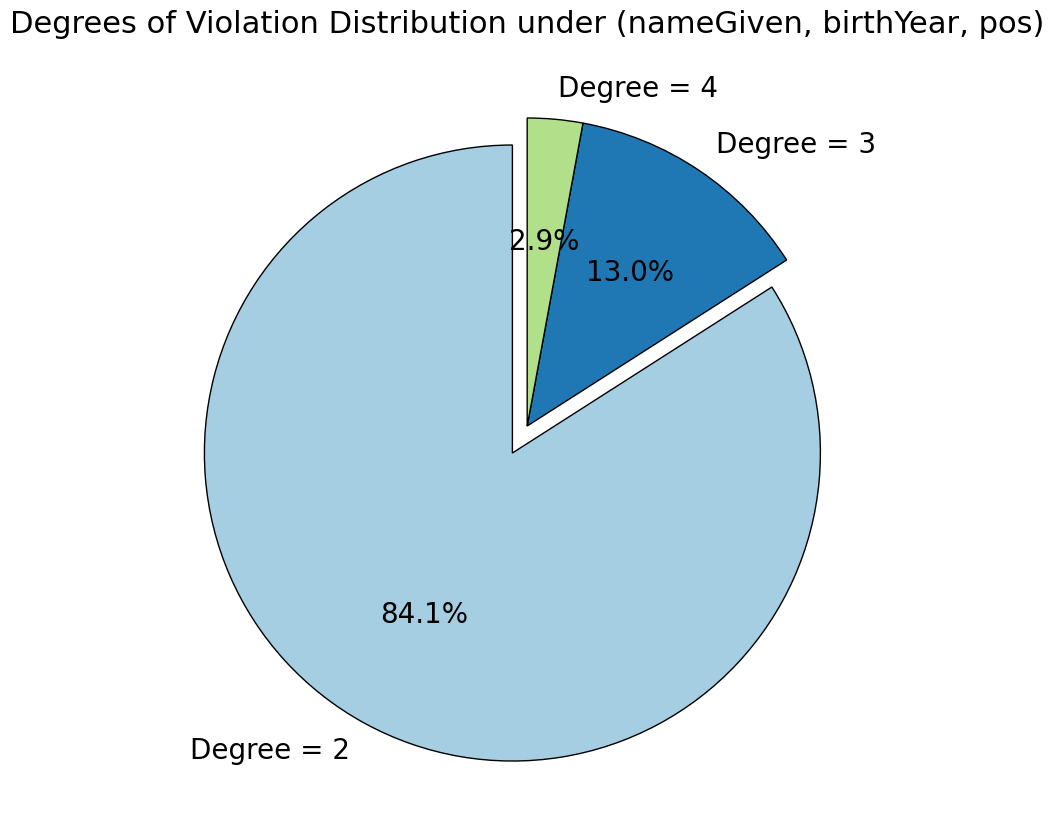


==================== Table: scoring; Near-key: ('playerID', 'year', 'stint') ====================

There are 2 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



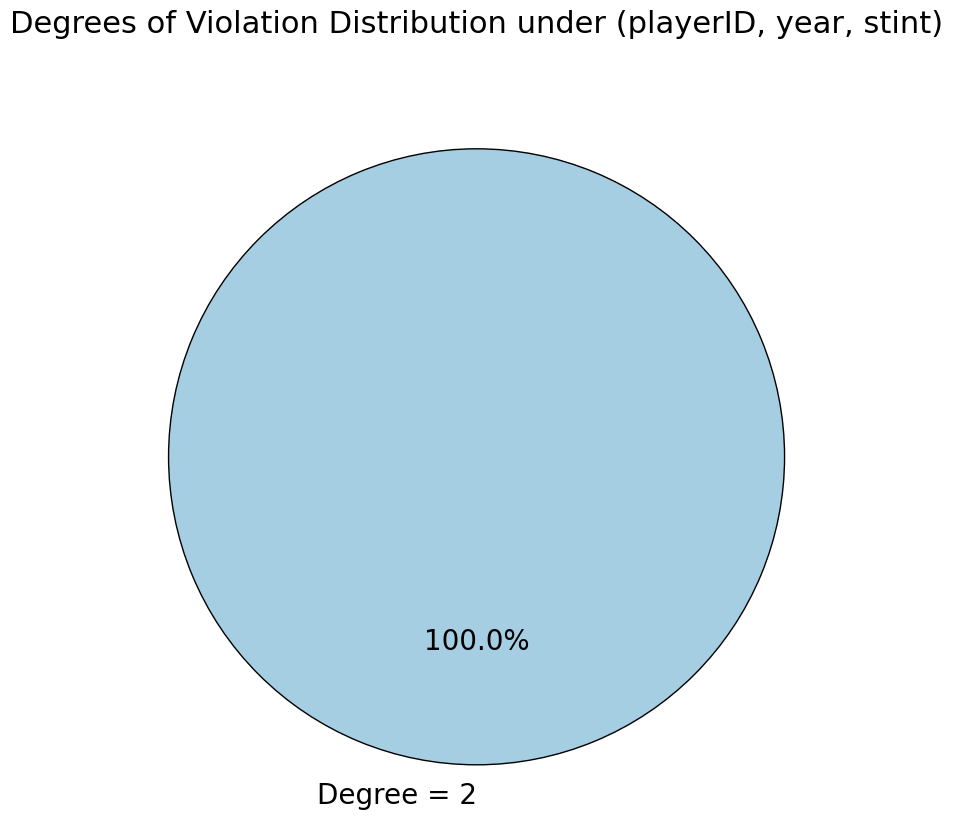


==================== Table: scoring; Near-key: ('playerID', 'year', 'tmID') ====================

There are 9 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



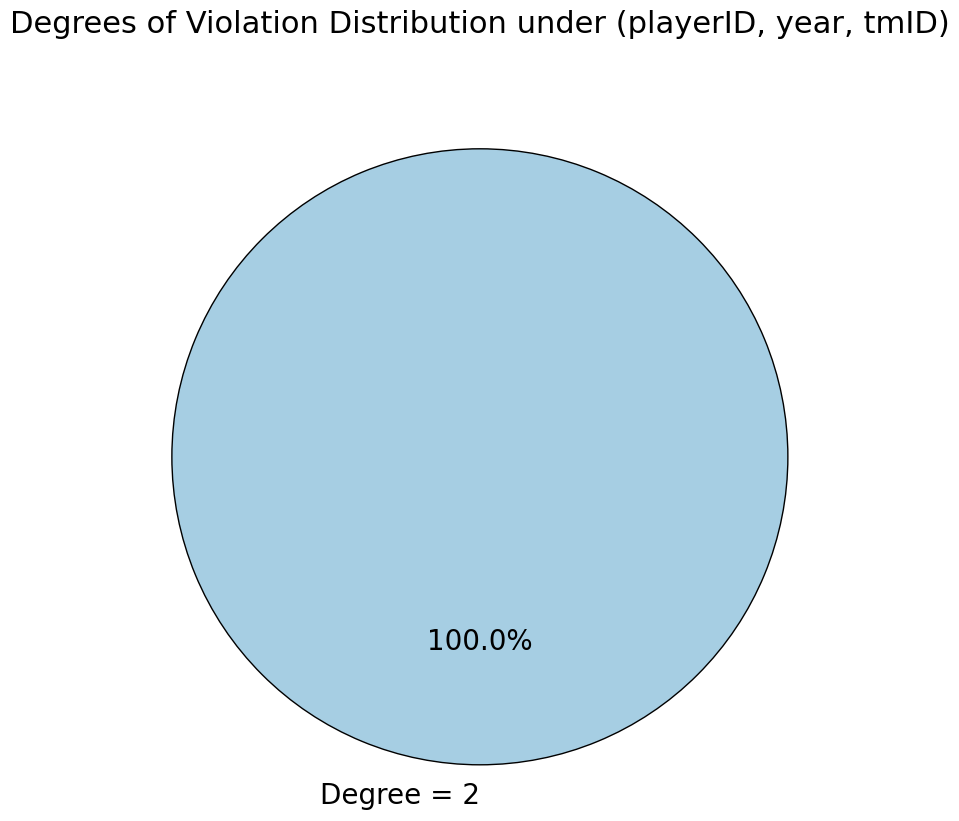


==================== Table: scoring; Near-key: ('playerID', 'year', 'stint', 'lgID') ====================

There are 2 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



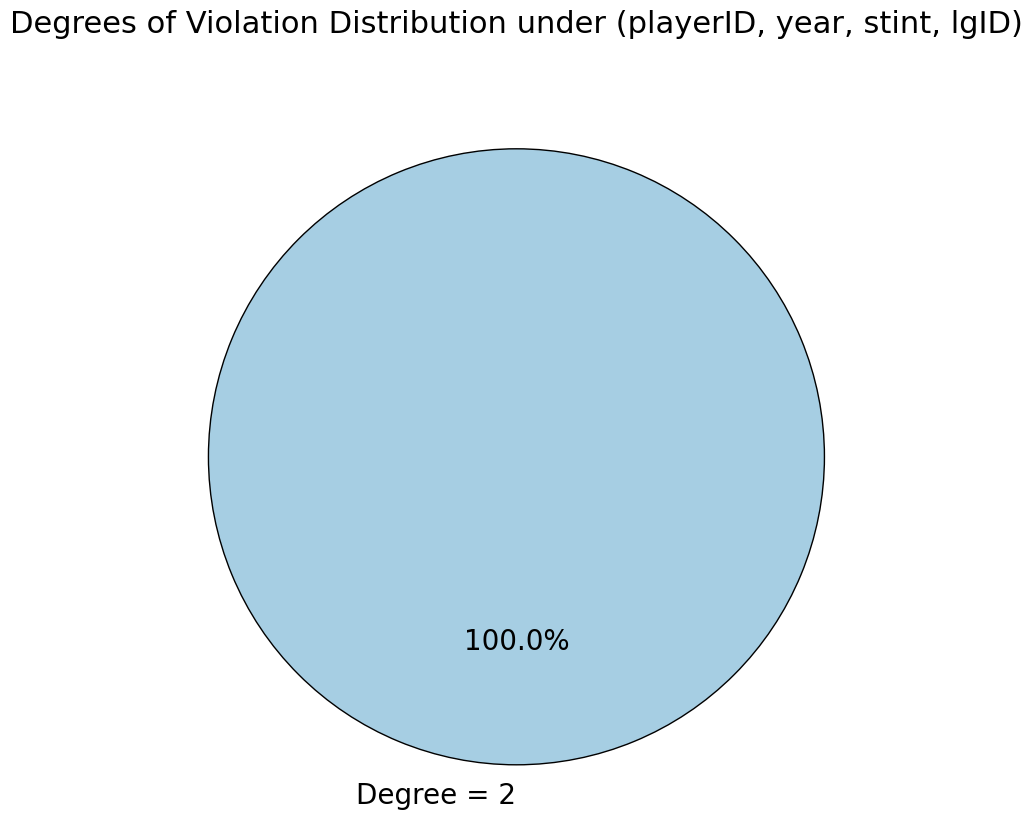


==================== Table: scoring; Near-key: ('playerID', 'year', 'tmID', 'lgID') ====================

There are 9 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



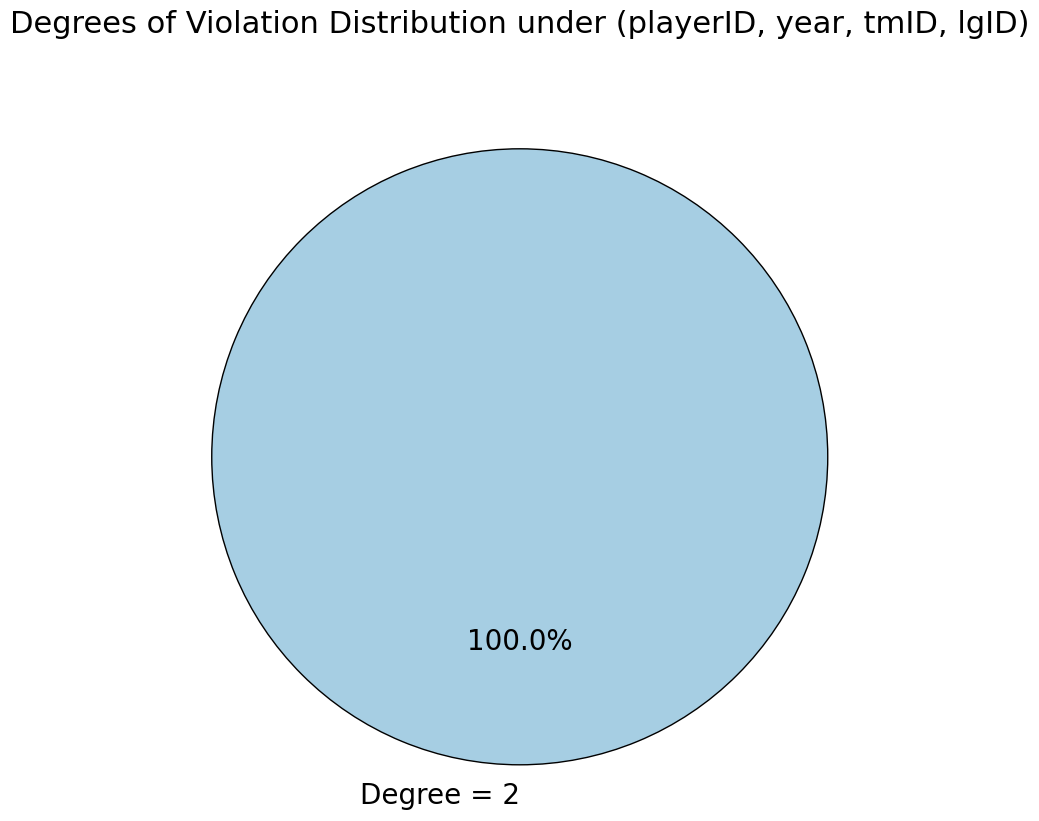


==================== Table: scoring; Near-key: ('playerID', 'year', 'tmID', 'pos') ====================

There are 9 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



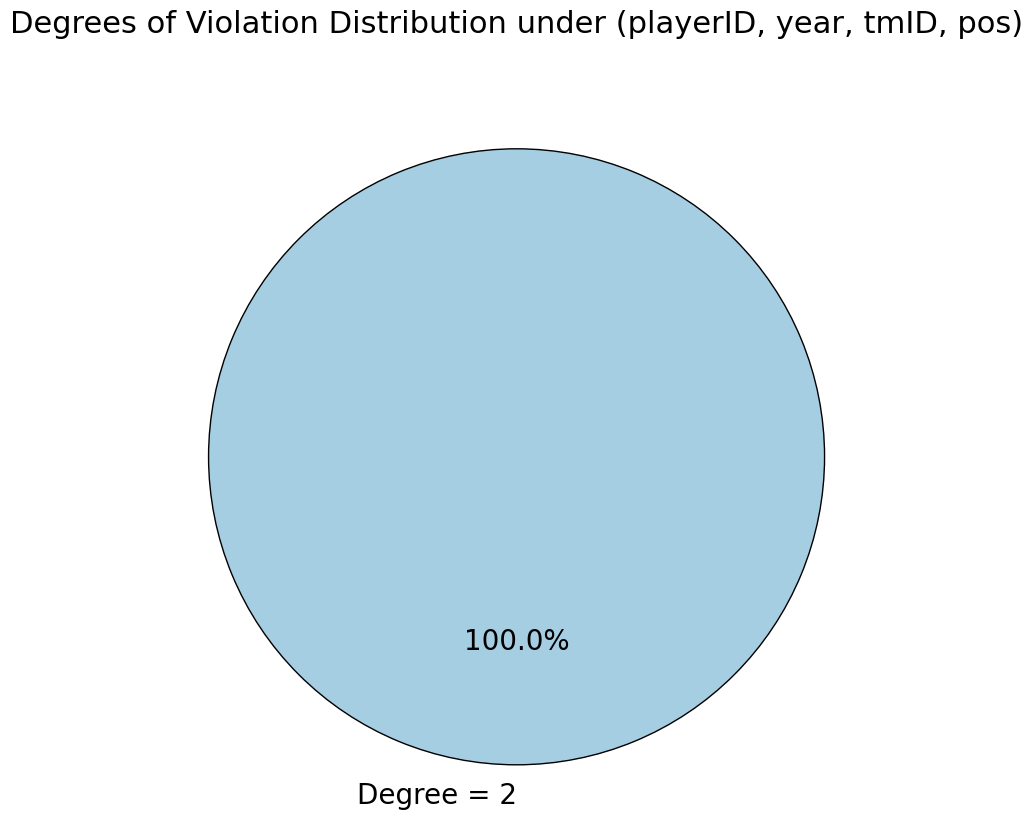


==================== Table: scoring; Near-key: ('playerID', 'year', 'tmID', 'lgID', 'pos') ====================

There are 9 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



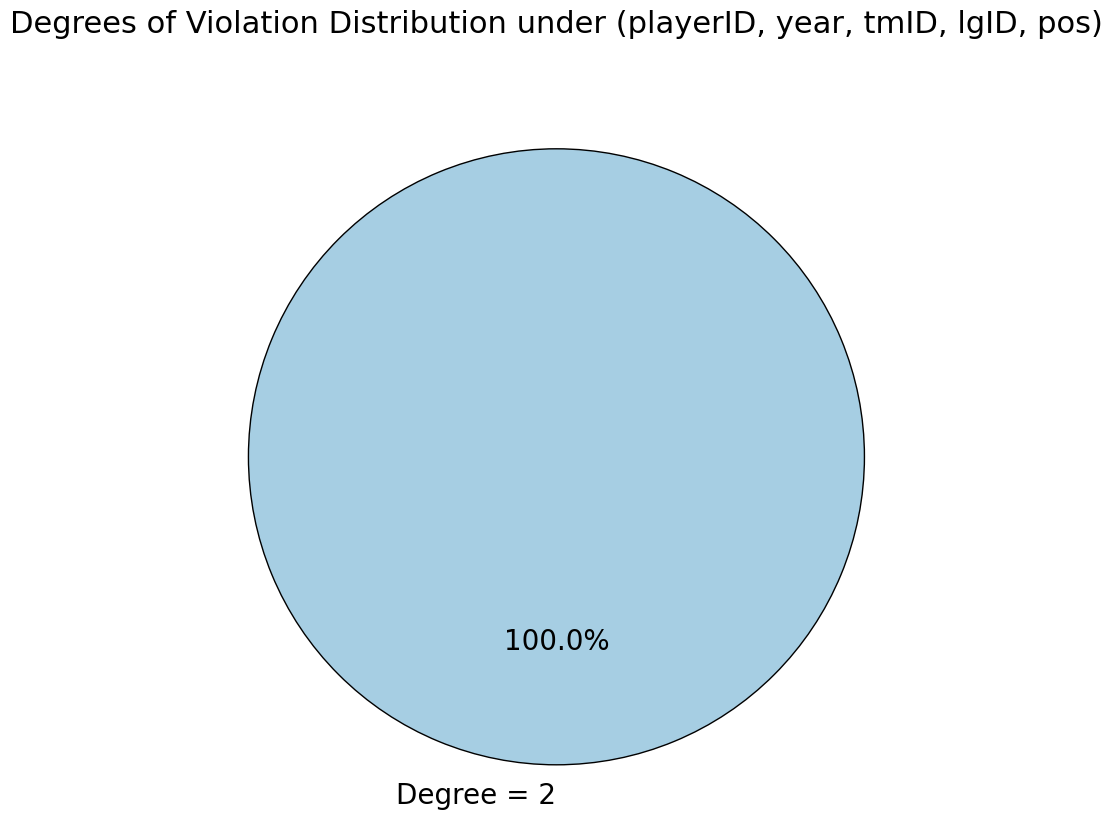


==================== Table: seriespost; Near-key: ('year', 'tmIDLoser') ====================

There are 3 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



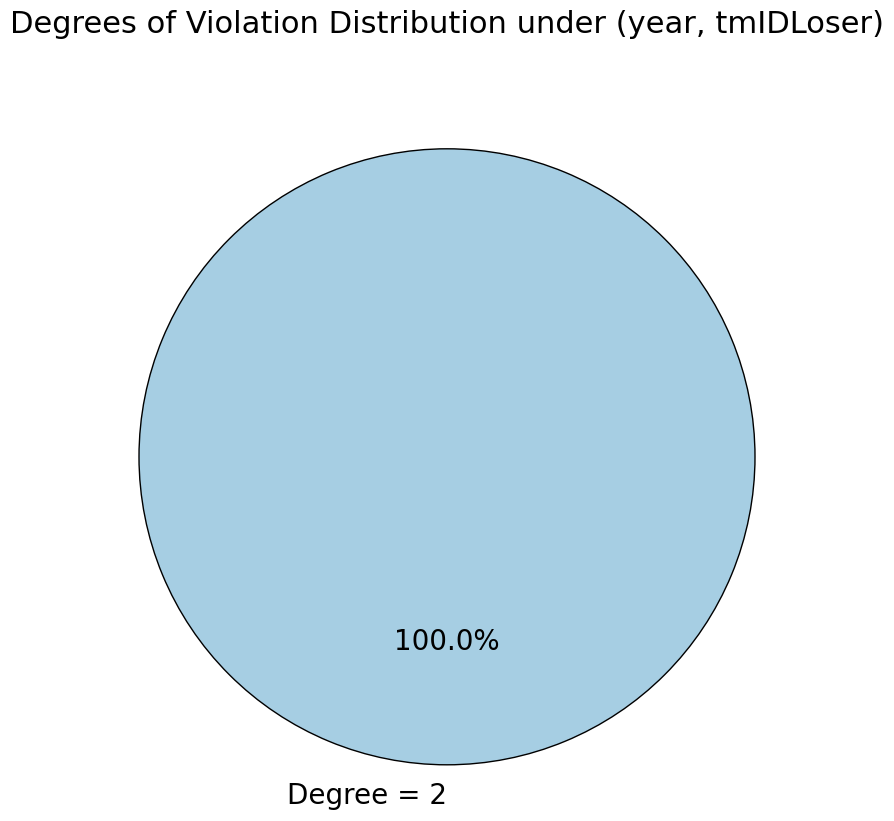


==================== Table: seriespost; Near-key: ('year', 'lgIDWinner', 'tmIDLoser') ====================

There are 2 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



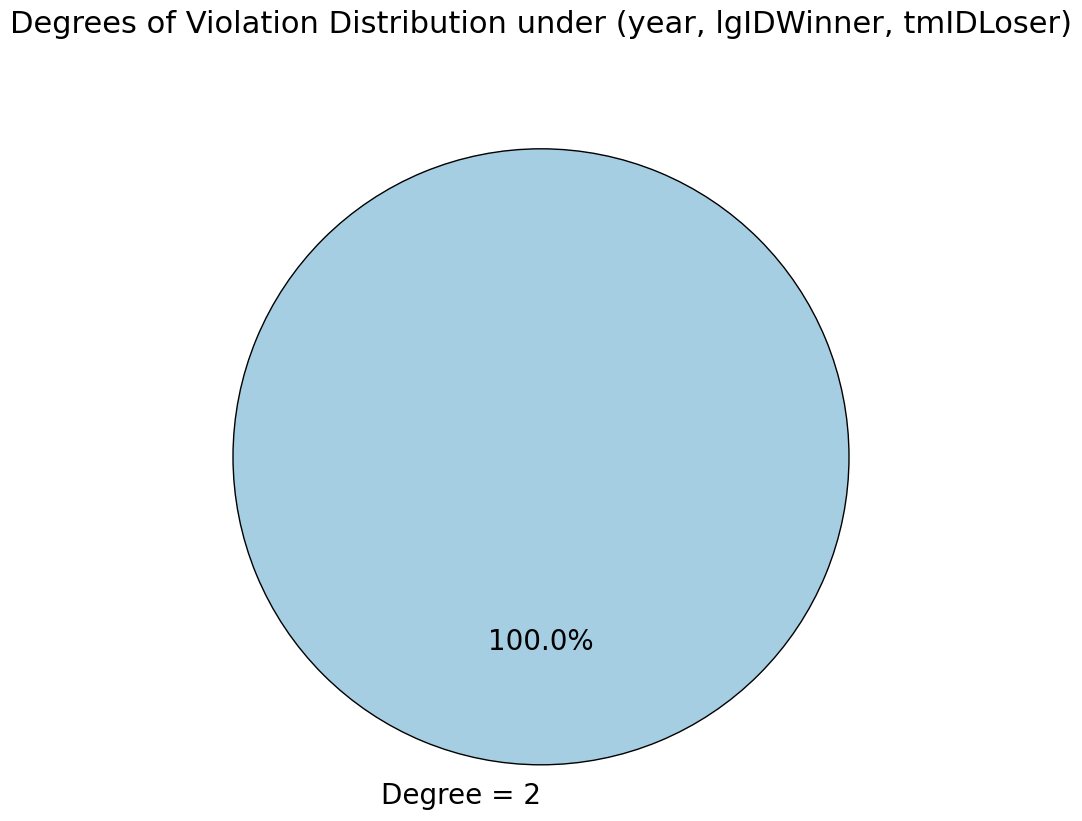


==================== Table: seriespost; Near-key: ('year', 'tmIDLoser', 'lgIDLoser') ====================

There are 3 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



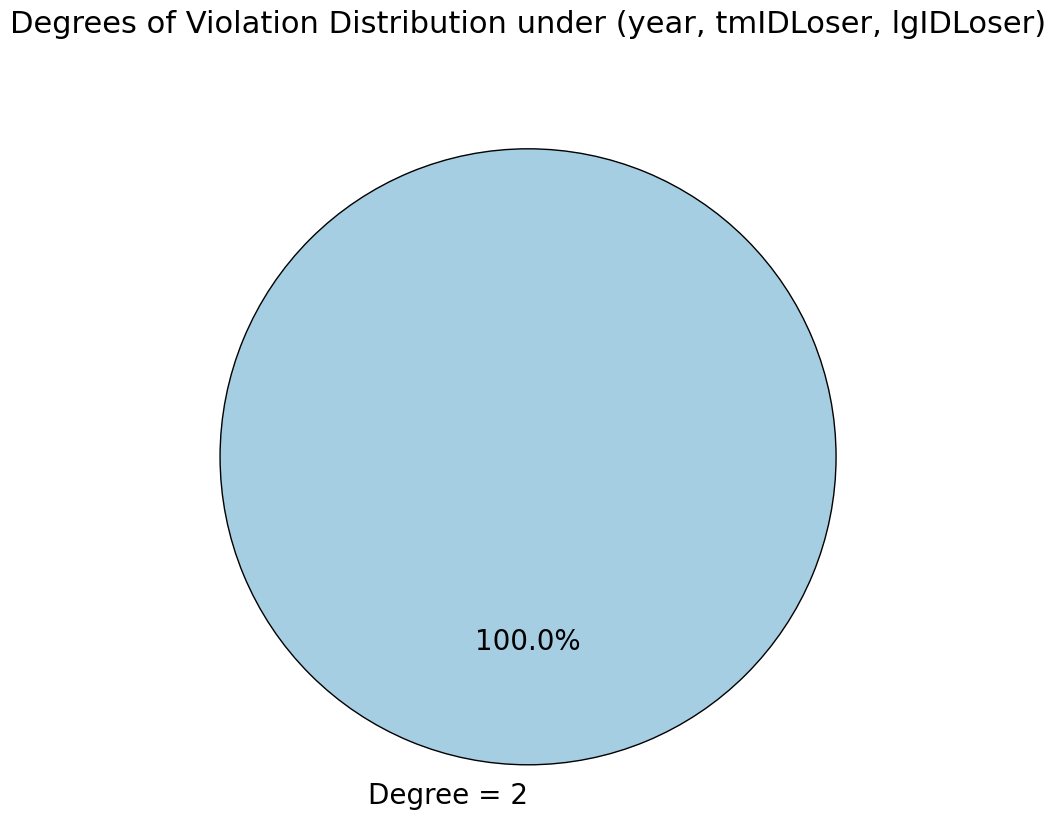


==================== Table: seriespost; Near-key: ('year', 'lgIDWinner', 'tmIDLoser', 'lgIDLoser') ====================

There are 2 entities in this table which the degree of violation is 2.

Degree of Duplication: 2



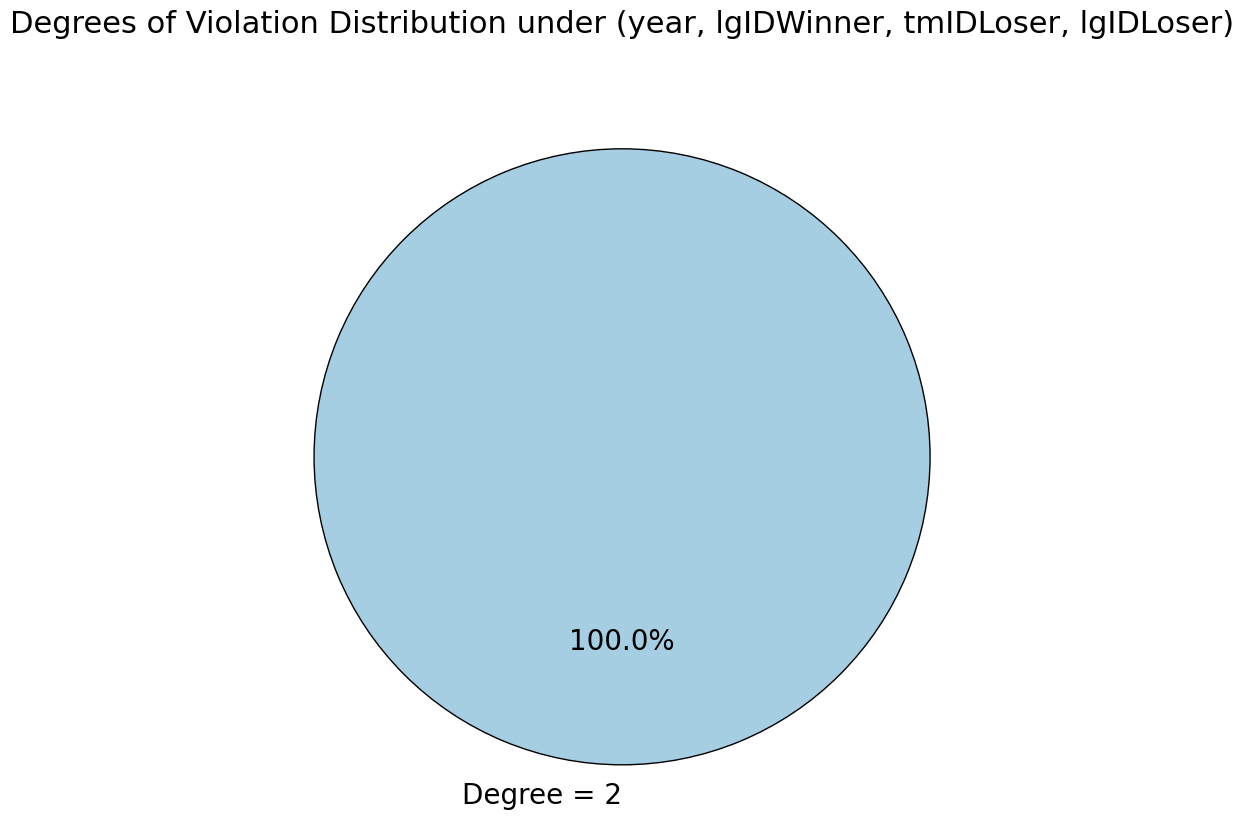

In [20]:
def degree_of_violation2(cursor, table_name, columns):
    if not columns:
        return {}
    
    # Query to find groups with duplicates (degree > 1)
    query_duplicates = f"""
        SELECT {', '.join([f"`{col}`" for col in columns])}, COUNT(*) AS group_count 
        FROM `{table_name}` 
        WHERE {' AND '.join([f"`{col}` IS NOT NULL" for col in columns])}
        GROUP BY {', '.join([f"`{col}`" for col in columns])}
        HAVING COUNT(*) > 1;
    """
    
    # Execute the query
    cursor.execute(query_duplicates)
    group_table = cursor.fetchall()

    # Process results for degrees
    duplicate_counts = {}
    for row in group_table:
        degree = row[-1]  # group_count is the last column
        # Increment the total number of rows for this degree
        duplicate_counts[degree] = duplicate_counts.get(degree, 0) + degree

    return duplicate_counts  # Contains total rows for each degree > 1


def plot_violation_pie_chart(columns, duplicate_counts):
    """
    Plot a pie chart for degrees of violation based on their total rows in all duplicates.
    
    :param duplicate_counts: A dictionary where keys are degrees and values are total rows.
    """
    # Prepare data
    x = list(duplicate_counts.keys())
    y = list(duplicate_counts.values())  # Total rows for each degree
    total = sum(y)  # Total rows across all degrees
    ratios = [count / total * 100 for count in y]  # Calculate ratios as percentages

    # Prepare labels for the pie chart
    labels = [f"Degree = {degree}" for degree in x]

    # Define colors for each segment
    colors = plt.cm.Paired.colors[:len(labels)]

    # Explode the first slice for emphasis
    explode = [0.1 if i == 0 else 0 for i in range(len(labels))]

    # Set font sizes globally
    plt.rcParams.update({
        'font.size': 20,       # General font size
        'axes.titlesize': 22,  # Title font size
        'axes.labelsize': 20   # Label font size
    })

    # Create the pie chart
    plt.figure(figsize=(10, 10))  # Increase figure size
    plt.pie(
        ratios,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        explode=explode,
        wedgeprops={'edgecolor': 'black'},
        textprops={'fontsize': 20}  # Increase text font size
    )

    # Set the title and show the chart
    plt.title(f"Degrees of Violation Distribution under ({', '.join(columns)})", fontsize=22)
    plt.show()


# Example usage in main_degree
def main_degree2(database, table_name, columns):
    try:
        connection = mysql.connector.connect(user="root", password="yzh_20010315", database=database)

        if connection.is_connected():
            cursor = connection.cursor()

            # Get degree counts (degree > 1)
            duplicate_counts = degree_of_violation2(cursor, table_name, columns)
            # print("Duplicate Counts:", duplicate_counts)

            # Plot the pie chart
            plot_violation_pie_chart(columns, duplicate_counts)

    except Error as e:
        print("Error:", e)
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()
# for key in nk_dic.items():
#     print(key)
for key, values in nk_dic.items():
    for value in values:
        if value[1] != 1:
            print(f"\n==================== Table: {key}; Near-key: {value[0]} ====================\n")
            main_degree('hockey', key, value[0])
            main_degree2('hockey', key, value[0])